# Análisis predictivo de series temporales

-----

## Modelos autorregresivos y autocorrelación parcial

### Introducción:

* En las clases anteriores introdujimos los conceptos de autocorrelación y correlación cruzada para analizar la relación entre una serie o series y sus versiones "laggeadas".

* Exploramos además cómo realizar regresiones lineales (con o sin lags) para explicar el comportamiento de una serie. Sirve para explicar tendencias, estacionalidad.

* Generalmente esto es *insuficiente* para explicar el comportamiento de una serie con dinámica interna.

* En general esto lo vimos como que "quedaba correlación" luego de los ajustes.

### Objetivos:

* Introducir la correlación como parte intrínseca de la serie. Hacer que los valores anteriores del proceso influyan directamente en el valor observado actual (autorregresivo, AR), y que valores anteriores del ruido influyan en el valor actual observado (media móvil, MA).

* Combinaciones de los dos anteriores da lugar a los modelos ARMA.

* Veremos cómo es posible:

  * Usar modelos ARMA para predecir valores futuros de una serie.
  * Ajustar los parámetros de un modelo ARMA a partir de observaciones.
  
* Si agregamos el caso no estacionario, veremos como *diferenciar* una serie puede producir estacionariedad. Esto da lugar a los modelos ARIMA (I=integrated).

### Definición:

Una *serie temporal* es una sucesión de variables aleatorias o *proceso estocástico* $x_0,x_1,x_2,\ldots$. La variable aleatoria $x_t$ denota el valor del proceso al tiempo $t$.

* Al proceso estocástico o serie temporal se lo denota por $\{x_t\}$.

* Típicamente (y para todo este curso) se consideran indexados por $t$ entero ($\ldots, -2, -1, 0, 1, 2, \ldots$).

* A los valores particulares que toma una serie temporal cuando la observamos se le denomina *realización* del proceso, y lo denotaremos por $x_t$, abusando un poco de la notación.

### Ruido blanco

__Definición:__ El caso más sencillo de serie temporal es un conjunto de variables aleatorias con la misma distribución y no correlacionadas. Si ${w_t}$ es una serie temporal en la cual las variables tienen media $E[w_t]=0$, varianza $Var(w_t) = \sigma_w^2 >0$ y la covarianza de $w_t$ y $w_s$ es $0$ se le denomina *ruido blanco*.  

__Definición:__ Si además las variables son independientes y con la misma distribución (iid), se le denomina ruido blanco independiente.

__Definición:__ En el caso que además la distribución de $w_t$ para cada $t$ sea Normal $N(0,\sigma_w^2)$ le llamamos *ruido blanco gaussianp*

In [2]:
install.packages("devtools")     # only need to do this once
devtools::install_github("nickpoison/astsa")
#install.packages("astsa")
library(astsa)
options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


also installing the dependencies ‘rematch2’, ‘usethis’, ‘callr’, ‘DT’, ‘glue’, ‘roxygen2’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




✔  checking for file ‘/tmp/RtmpR3OZNK/remotes2a2af1474c/nickpoison-astsa-82fb863/DESCRIPTION’
─  preparing ‘astsa’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘astsa_1.10.tar.gz’
   


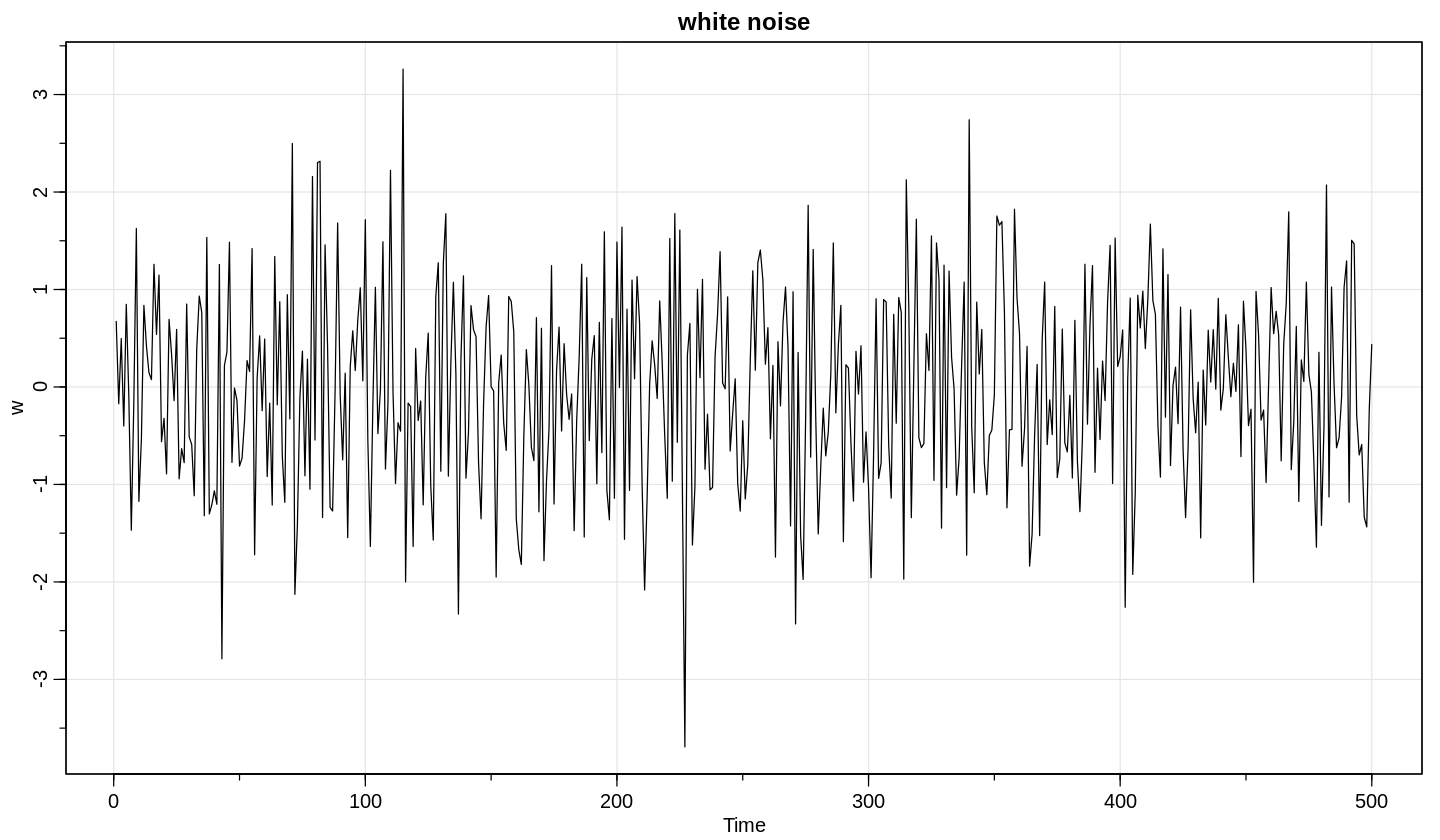

In [3]:
w = rnorm(500,0,1)  # 500 N(0,1) variates
tsplot(w, main="white noise")

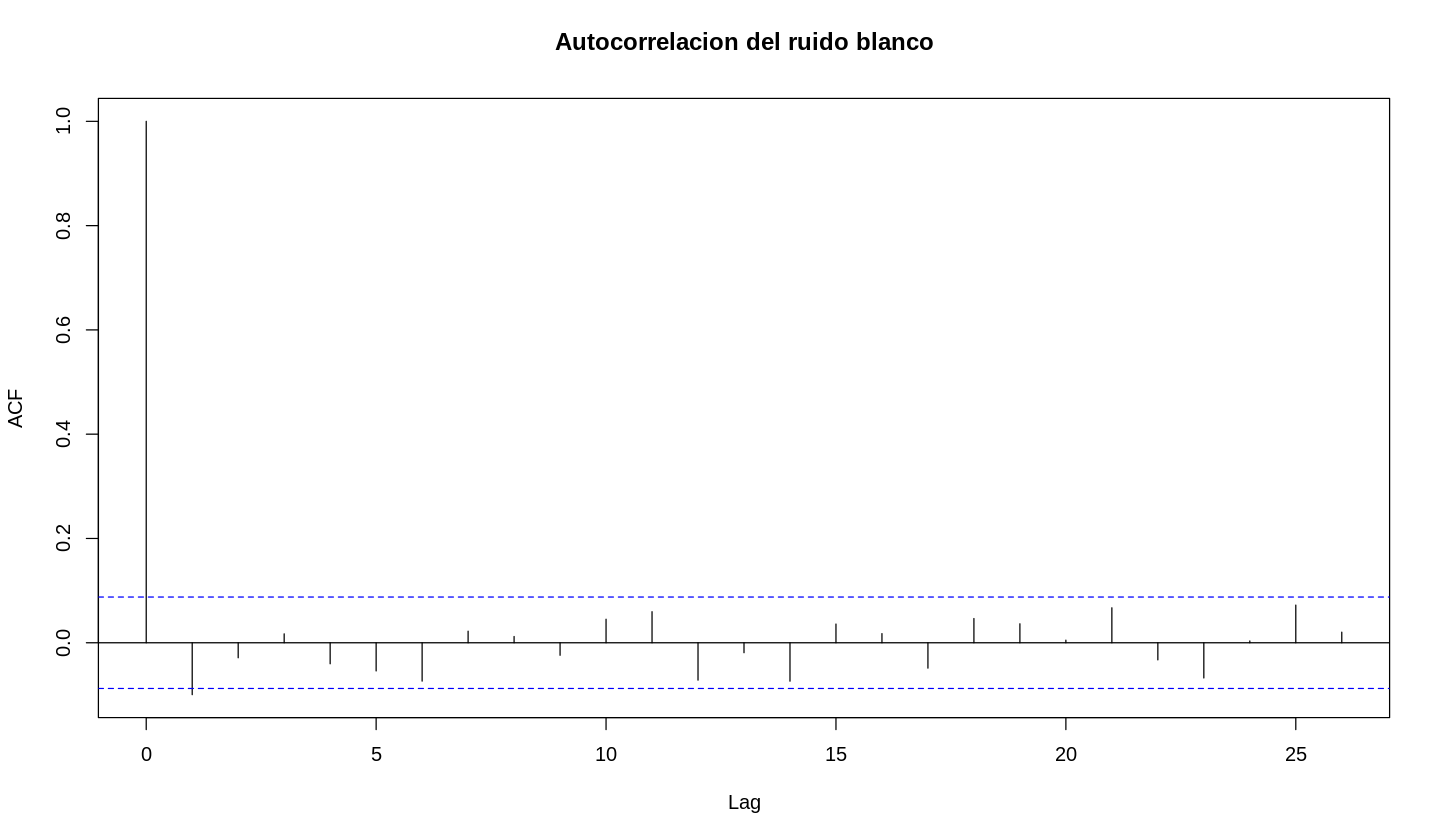

In [4]:
acf(w, main="Autocorrelacion del ruido blanco")

### Modelos autorregresivos

**Idea:** el valor del proceso en tiempo $t$ es una combinación lineal de los últimos $p$ valores de la serie, más una *innovación* o *ruido* que afecta solo al tiempo $t$.

> **Ejemplo:**
>
>Consideremos el proceso:
> $$x_t = x_{t-1} -0.9 x_{t-2} + w_t.$$
>
> Con $x_{0}$ y $x_{-1}$ dados (por ejemplo 0).

Este es un proceso *autorregresivo de orden 2*.

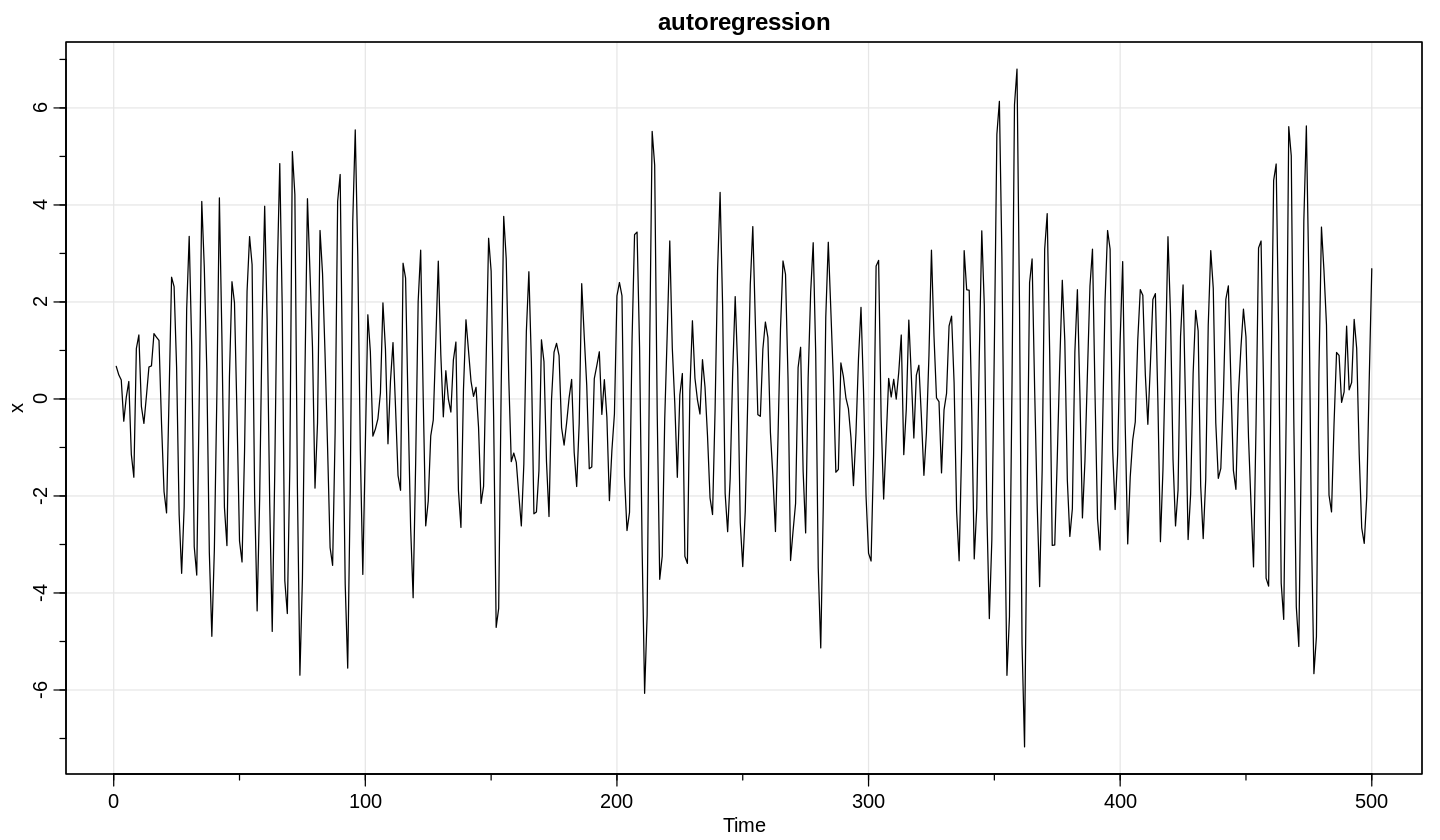

In [5]:
#esto se construye con el comando "filter" de R
x = filter(w, filter=c(1,-.9), method="recursive")
tsplot(x, main="autoregression")

### Autocorrelación del proceso:

Uno tiende a pensar que la autocorrelación del proceso solo tendrá valores significativos para los 2 anteriores. **FALSO**

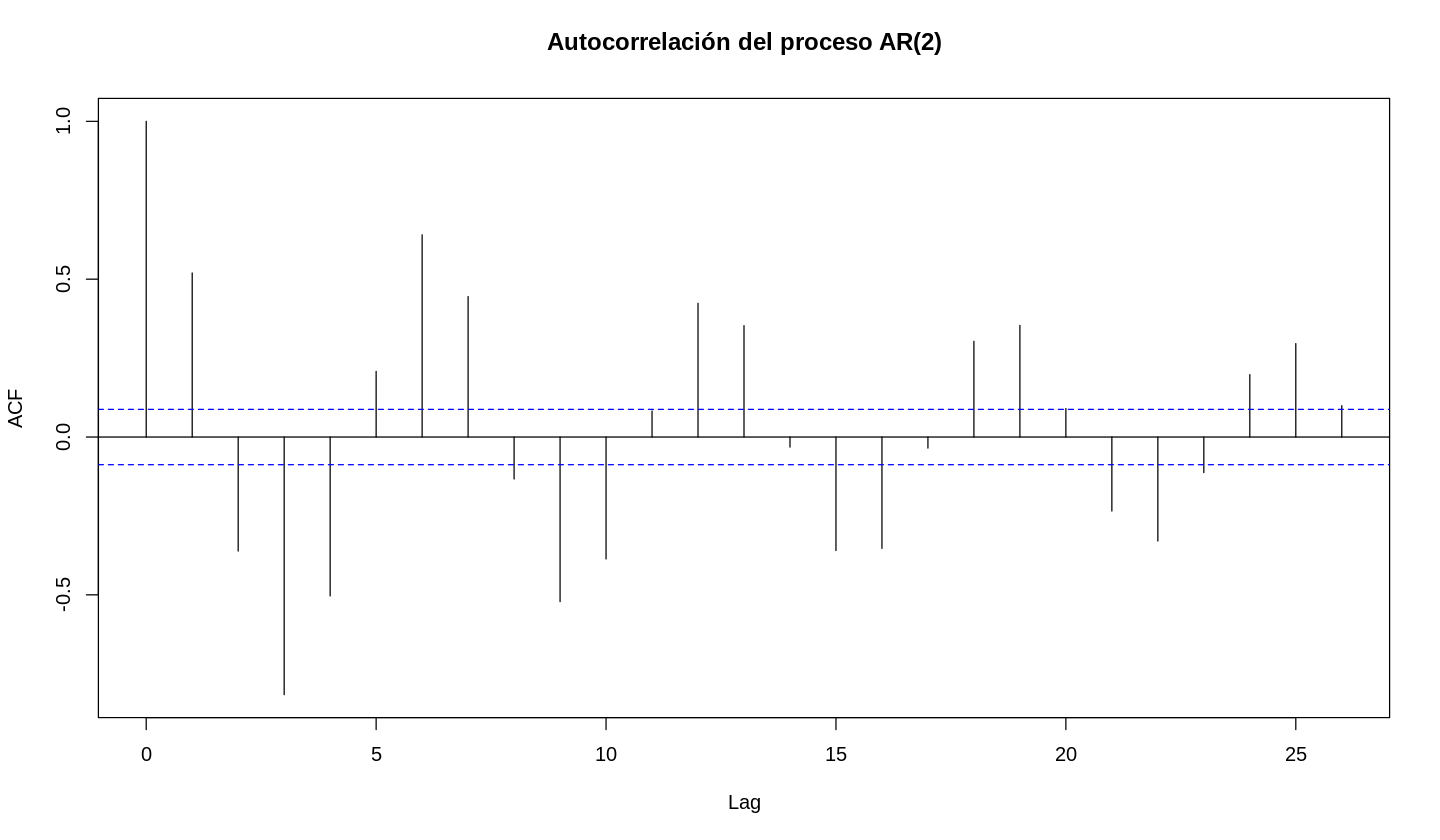

In [6]:
acf(x, main="Autocorrelación del proceso AR(2)")

> **Ejemplo:**
>
>Consideremos el proceso:
> $$x_t = 0.9 x_{t-1} + w_t.$$
>
> Con $x_{0}$ dado (por ejemplo 0).

Este es un proceso *autorregresivo de orden 1*. Cada muestra recuerda a la anterior.

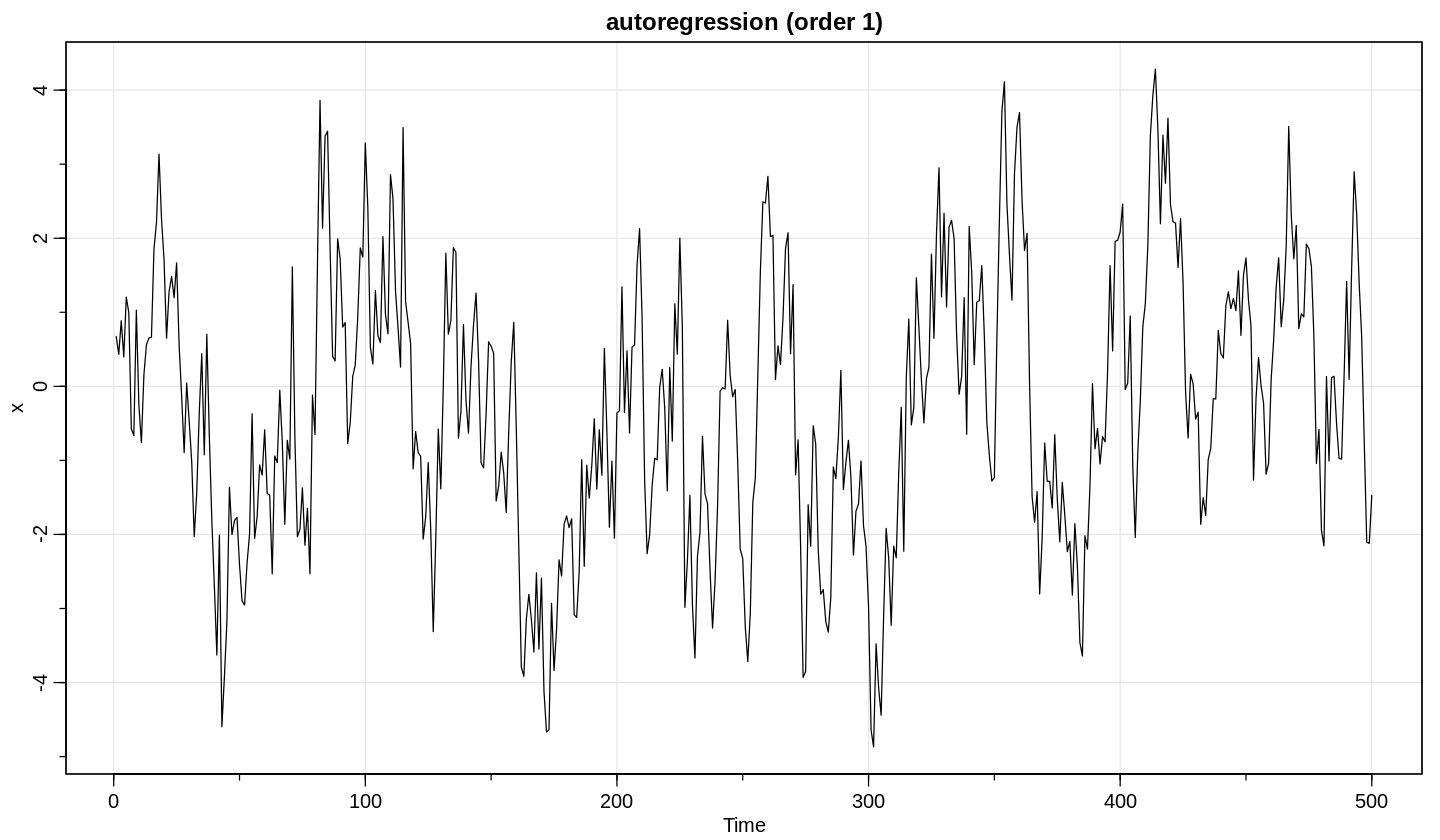

In [7]:
#esto se construye con el comando "filter" de R
x = filter(w, filter=c(0.9), method="recursive")
tsplot(x, main="autoregression (order 1)")

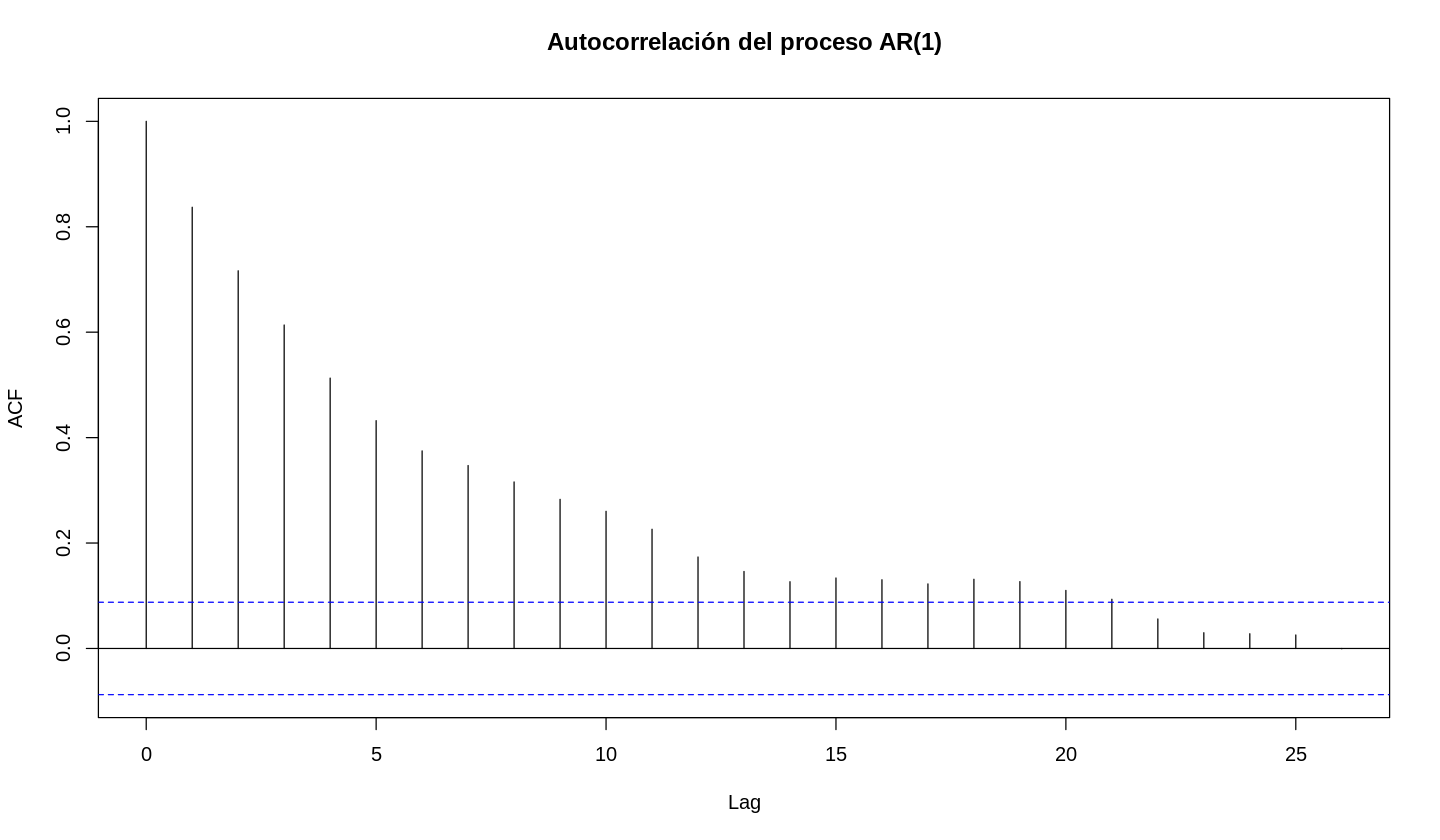

In [8]:
acf(x, main="Autocorrelación del proceso AR(1)")

**Pregunta:** ¿Cómo podemos determinar el orden de un proceso de este tipo? ¿Cómo podemos determinar sus parámetros?

### Estimación de un AR(1)

Probemos mirar la correlación entre un valor y el anterior:

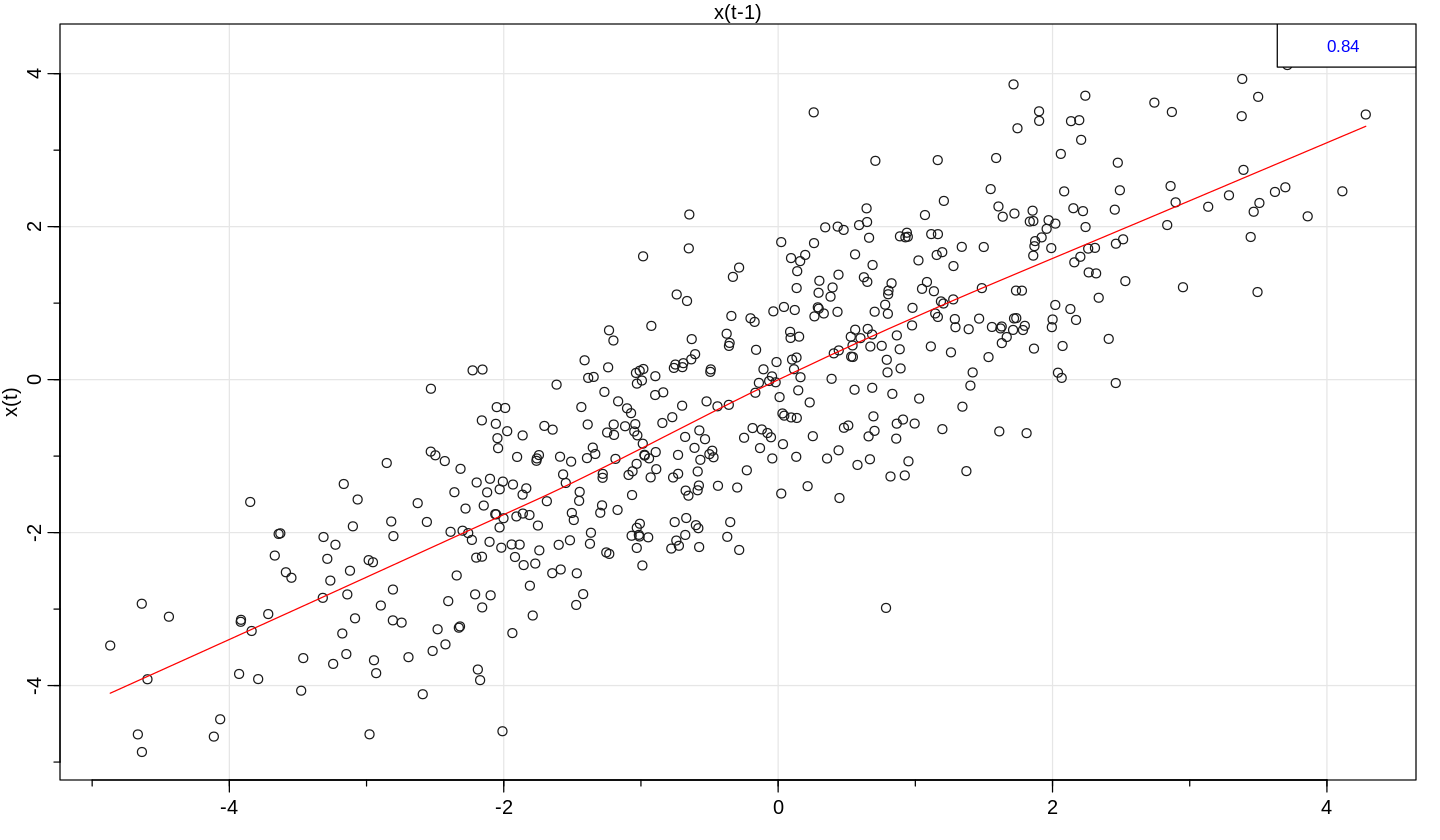

In [9]:
#Este comando plotea x_t vs x_t-1
lag1.plot(x,1)

In [10]:
dos_series = ts.intersect(x,xt1=lag(x,-1))
fit <- lm(x~0+xt1,data=dos_series)
summary(fit)


Call:
lm(formula = x ~ 0 + xt1, data = dos_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6469 -0.7741 -0.0375  0.6856  3.2758 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1   0.8423     0.0242   34.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9974 on 498 degrees of freedom
Multiple R-squared:  0.7087,	Adjusted R-squared:  0.7081 
F-statistic:  1212 on 1 and 498 DF,  p-value: < 2.2e-16


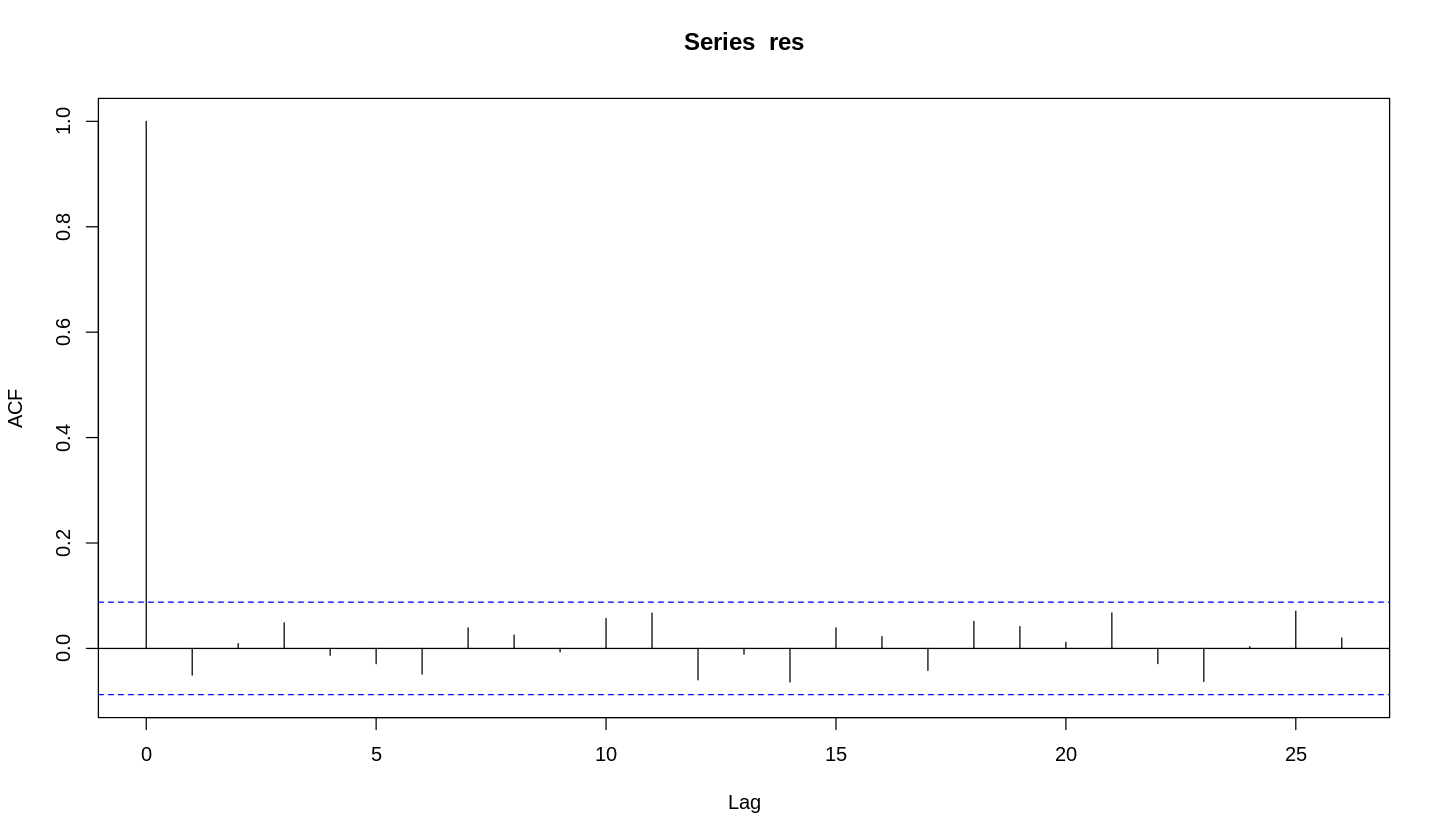

In [11]:
#Miramos los residuos del ajuste
res = residuals(fit)
acf(res)

### Probemos ahora con el AR(2)

$$x_t = x_{t-1} - 0.9x_{t-2} + w_t.$$

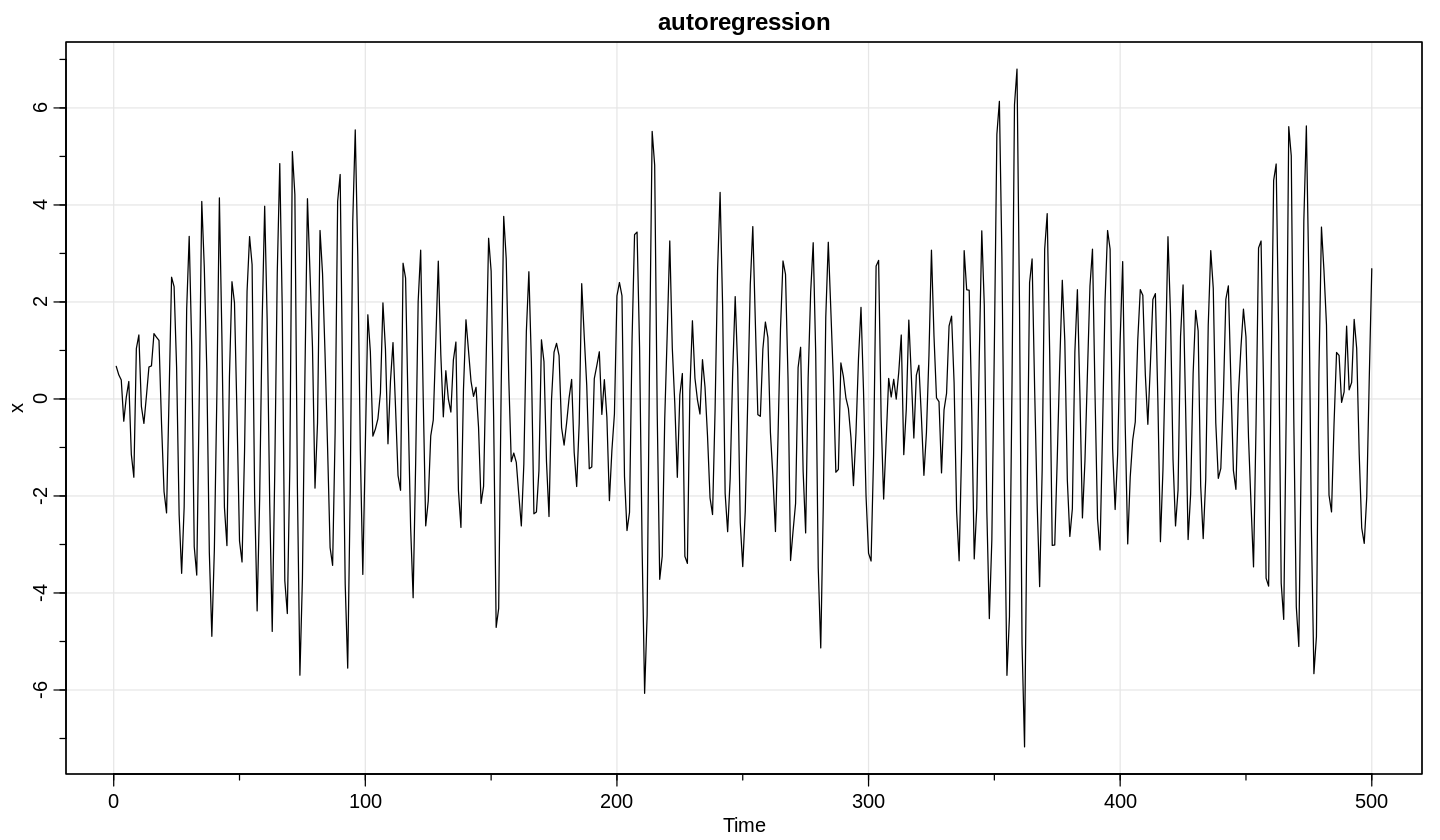

In [12]:
#esto se construye con el comando "filter" de R
x = filter(w, filter=c(1,-.9), method="recursive")
tsplot(x, main="autoregression")

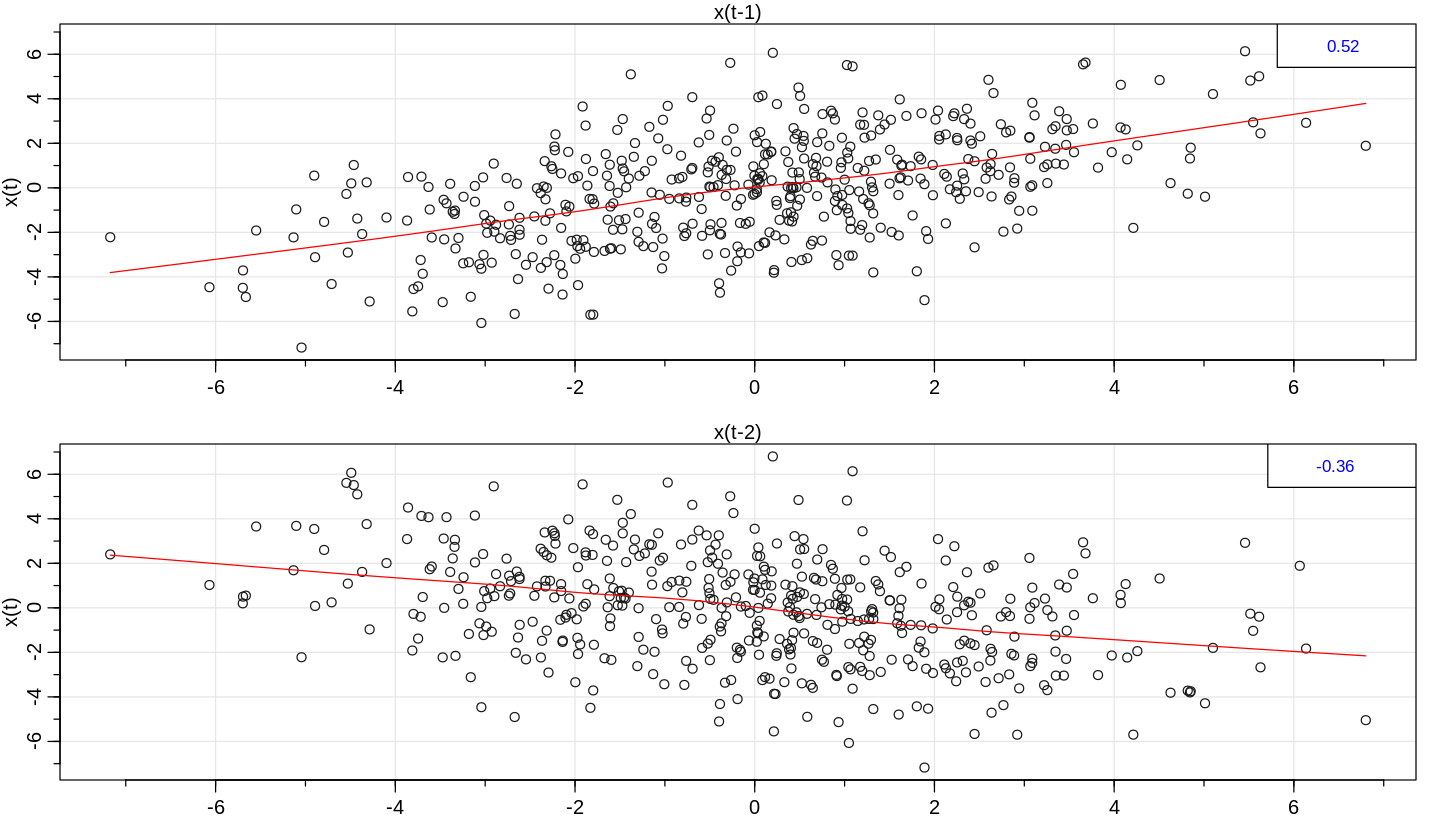

In [13]:
lag1.plot(x,2)

In [14]:
tres_series = ts.intersect(x,xt1=lag(x,-1),xt2=lag(x,-2))
fit <- lm(x~0+xt1+xt2,data=tres_series)
summary(fit)


Call:
lm(formula = x ~ 0 + xt1 + xt2, data = tres_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6811 -0.7520 -0.0467  0.6889  3.2602 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.97353    0.02237   43.52   <2e-16 ***
xt2 -0.86878    0.02237  -38.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.003 on 496 degrees of freedom
Multiple R-squared:  0.8196,	Adjusted R-squared:  0.8189 
F-statistic:  1127 on 2 and 496 DF,  p-value: < 2.2e-16


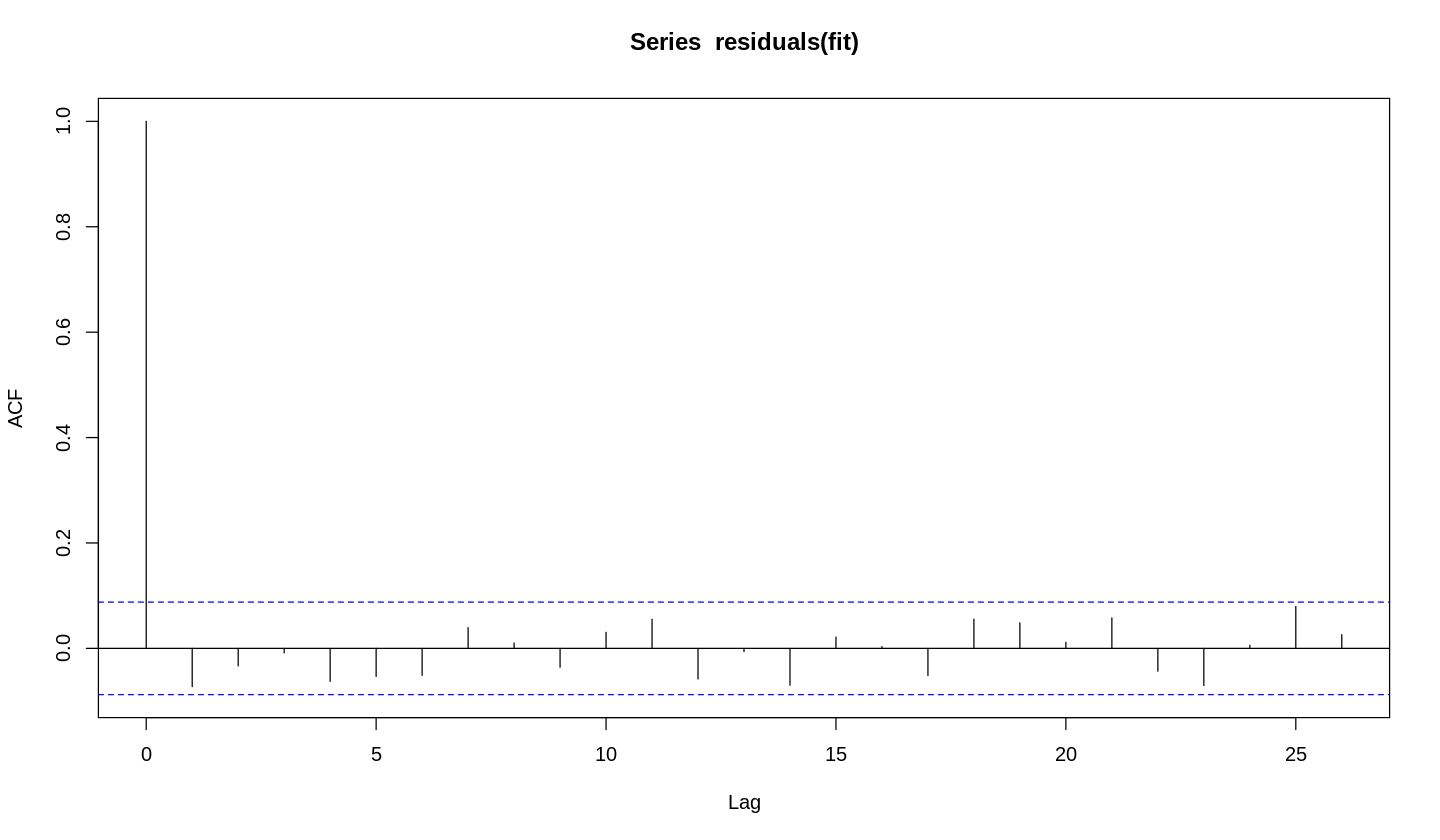

In [15]:
acf(residuals(fit))

Comparemos los residuos con el ruido que dio origen a la serie:

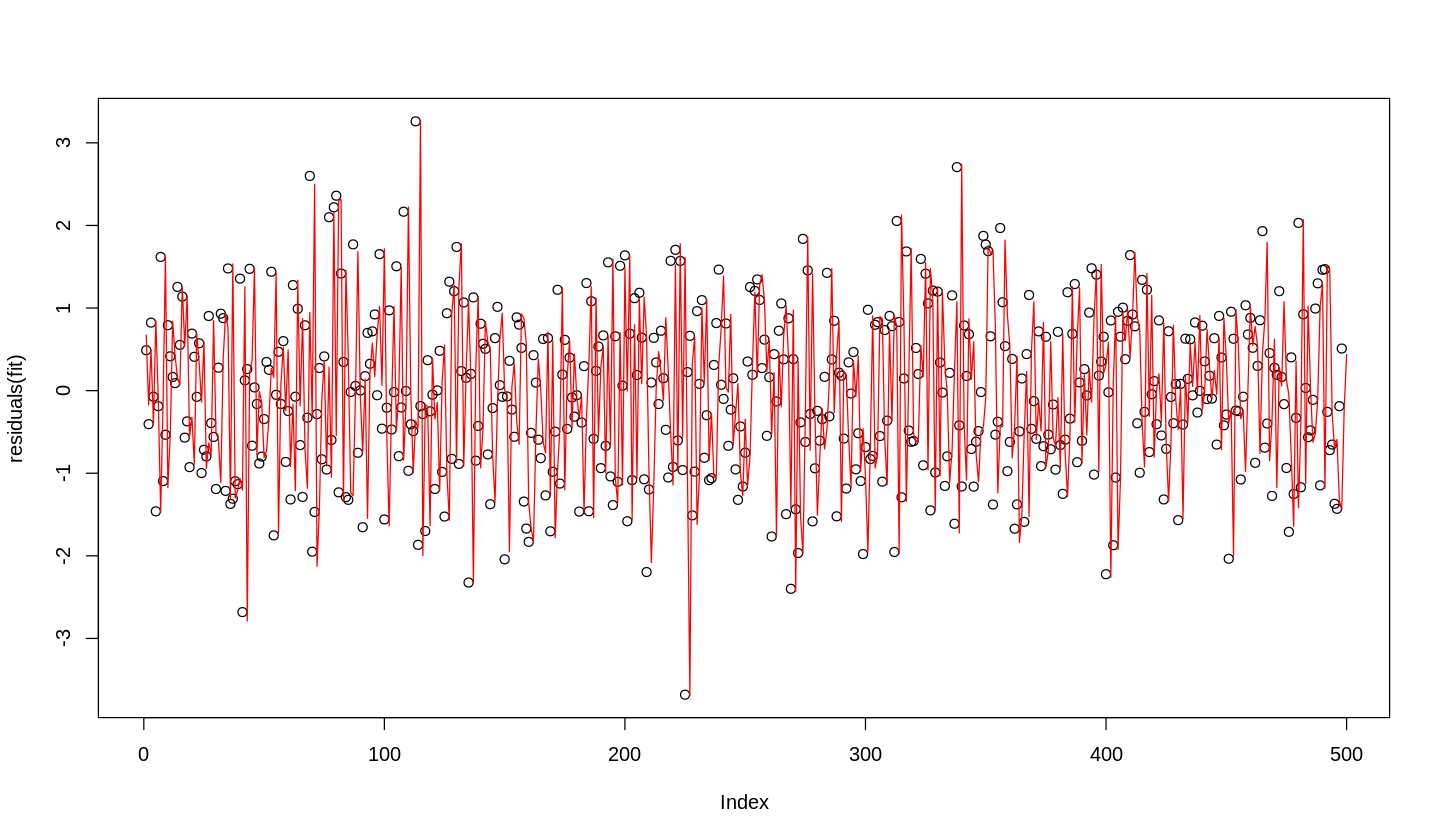

In [16]:
plot(residuals(fit))
lines(w,col="red")

### Conclusiones:

* En un modelo AR(p), cada muestra depende del ruido actual y de una combinación lineal de las observaciones anteriores

* La autocorrelación de todos modos depende de todas las muestras que vinieron antes!

* Si conocemos el *orden* del modelo, podemos hacer una regresión lineal para explicar $x_t$ a partir de $x_{t-1}$ hasta $x_{t-p}$. De ese modo se obtienen los valores de los coeficientes.

* Si el proceso ajusta, los residuos deben coincidir con los del ruido blanco y se parecen al ruido que dio origen a la serie.

### ¿Cómo averiguamos el orden del modelo? Función de autocorrelación parcial (PACF)

**Idea:** construir una función de correlación que solo contenga los aportes "incrementales" de agregar un lag, y no la correlación completa.

Se explica mejor a través de un ejemplo, dejaremos la teoría para más adelante.

Retomemos la serie:

$$x_t = x_{t-1} - 0.9 x_{t-2} + w_t.$$

Recordemos la función de autocorrelación (ACF)

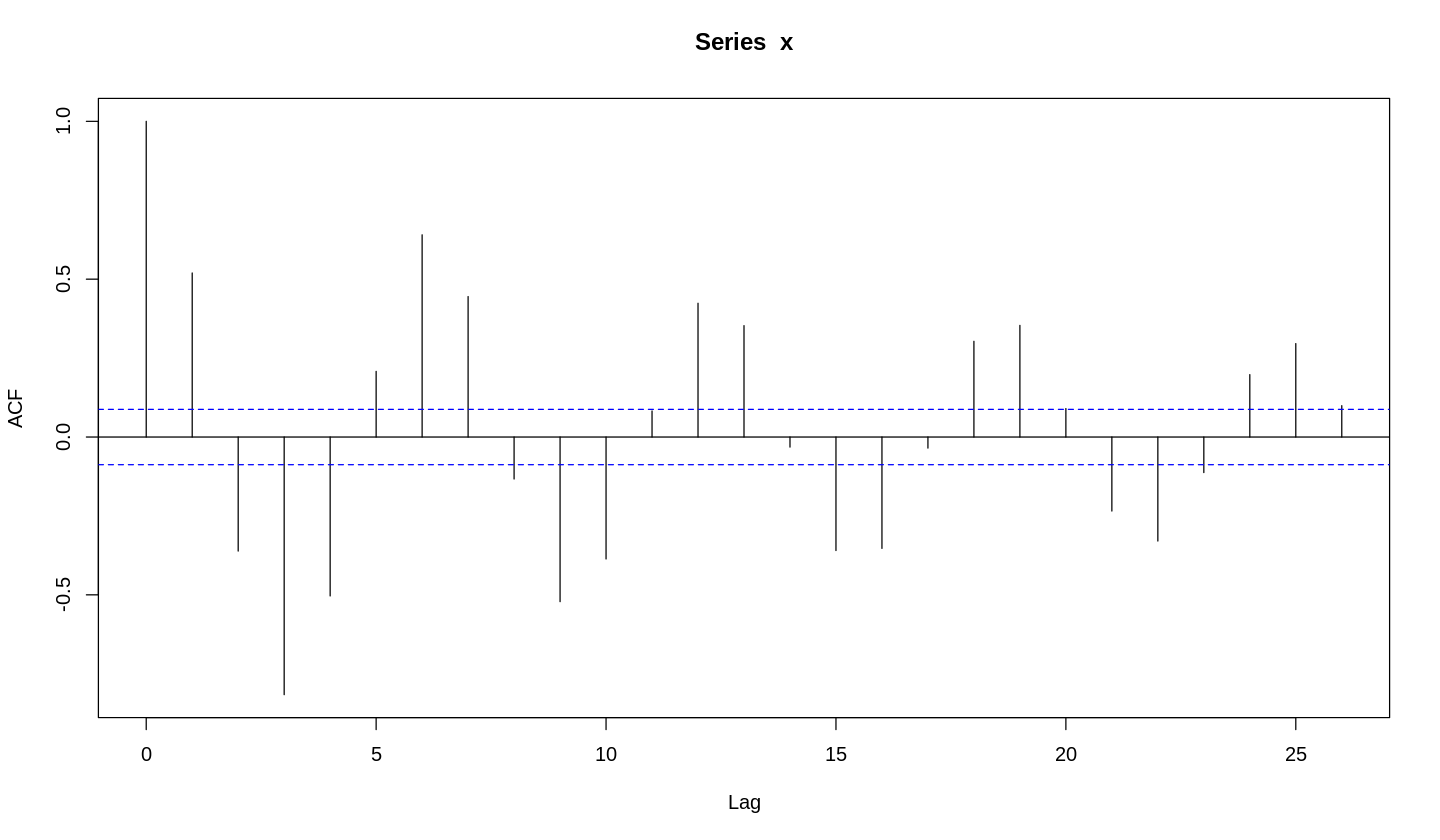

In [17]:
acf(x)

**Paso 1:** Ajustamos $x_t$ a $x_{t-1}$:

In [18]:
#Corto la serie x con la serie x laggeada
dos_series = ts.intersect(x,xt1=lag(x,-1))
#Ajusto
fit1 <- lm(x~0+xt1,data=dos_series)
summary(fit1) #el coef. hallado es la correlación de xt y xt-1, es decir acf(1)


Call:
lm(formula = x ~ 0 + xt1, data = dos_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0284 -1.4550  0.0005  1.4021  5.9607 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.52112    0.03831    13.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.012 on 498 degrees of freedom
Multiple R-squared:  0.2709,	Adjusted R-squared:  0.2694 
F-statistic:   185 on 1 and 498 DF,  p-value: < 2.2e-16


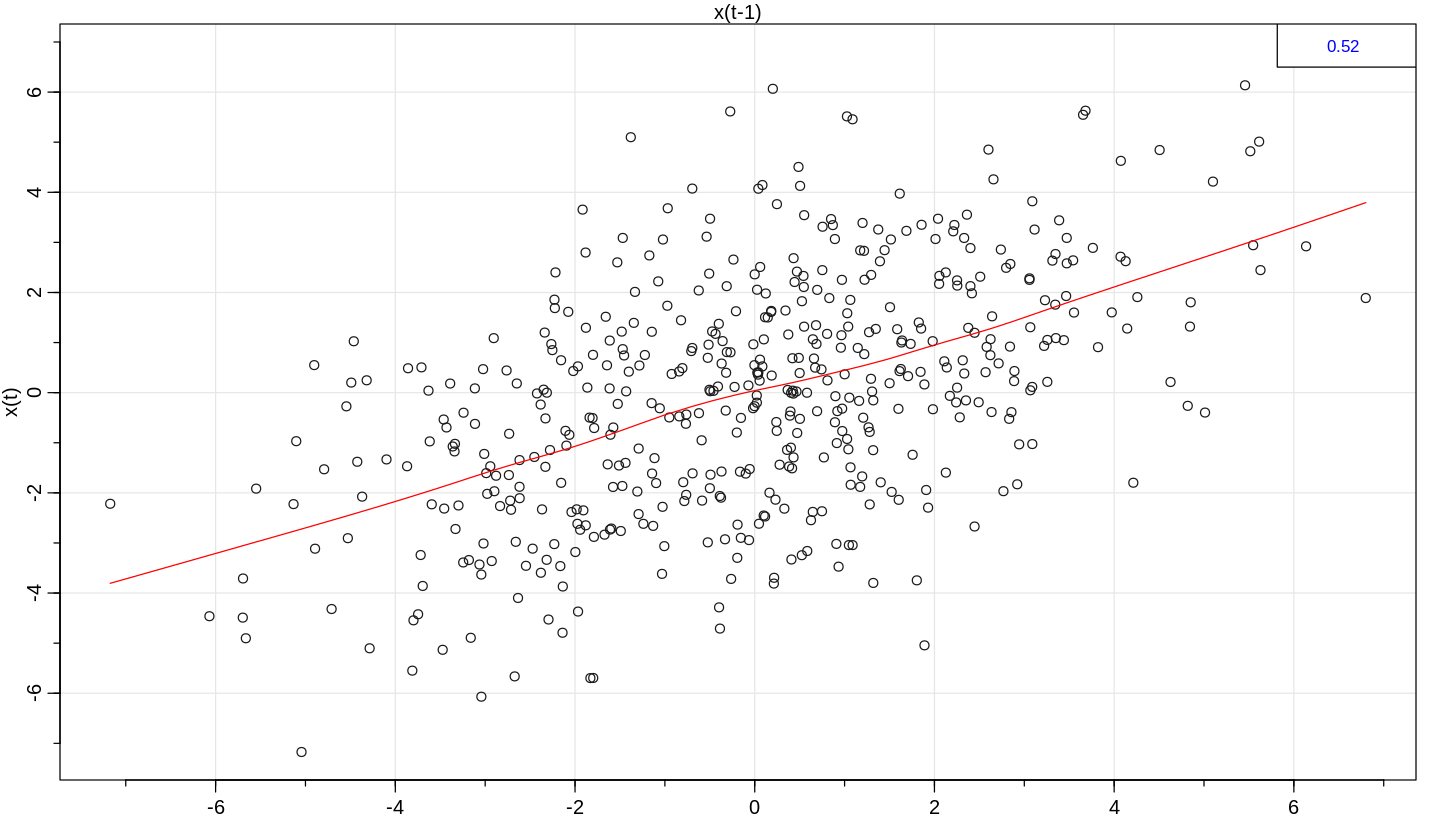

In [19]:
lag1.plot(x,1)

In [20]:
#capturo los residuos del ajuste anterior y construyo una serie temporal
r1 = residuals(fit1)
r1=ts(r1)

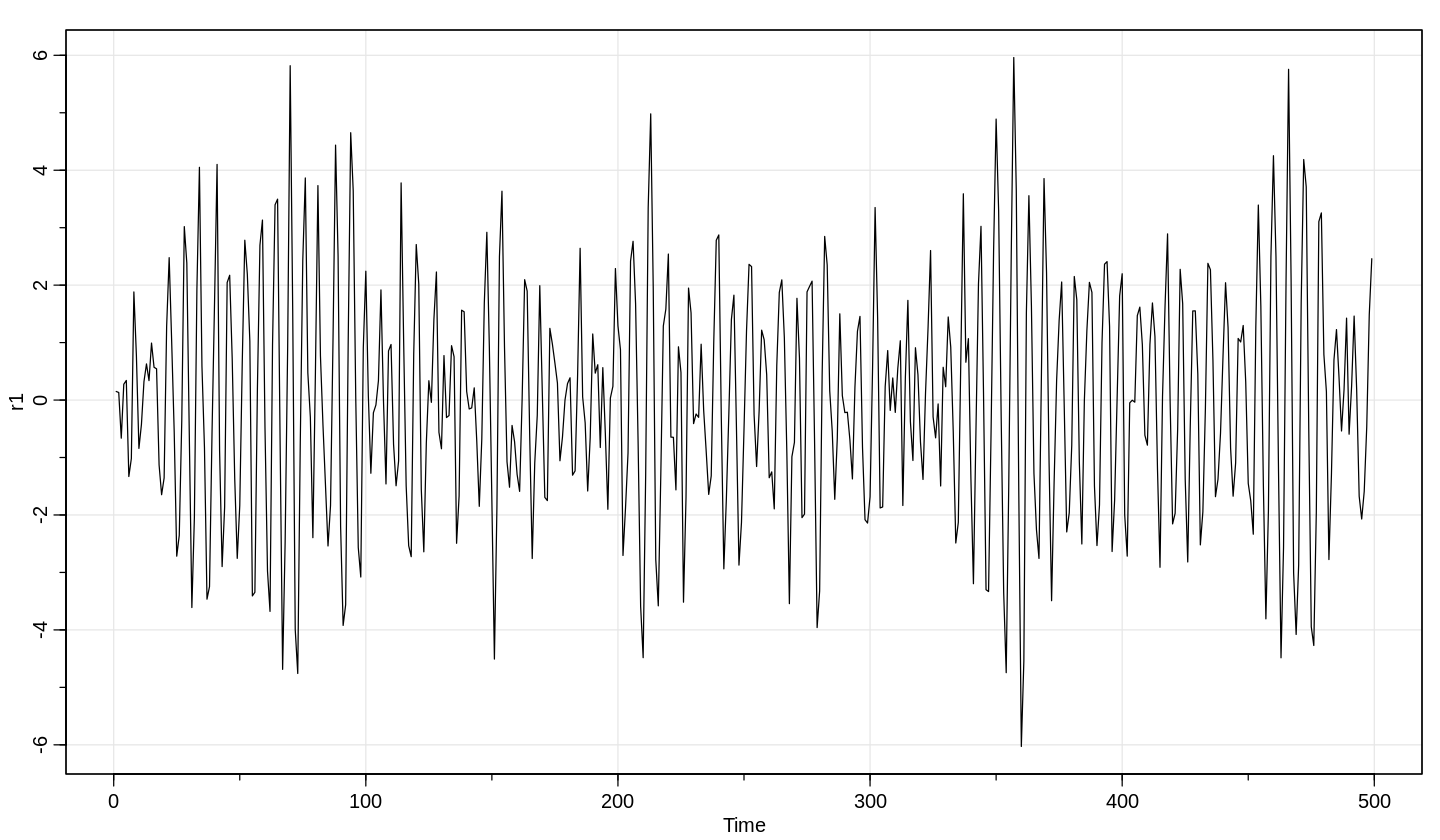

In [21]:
tsplot(r1)

* Si el proceso fuera de orden $1$, entonces una vez que conozco $x_{t-1}$, $x_t$ queda determinado a menos del ruido, por lo que el residuo no debería tener información.

* La serie anterior todavía no está del todo "blanca" quiere decir que debemos seguir un paso más.

* Problema: no alcanza con mirar otro lag, debemos "extraer" la información de $x_{t-2}$ que persiste en $x_t$.

* Para ello, miramos los residuos de los dos ajustes siguientes:

    * Ajusto $x_t$ a $x_{t-1}$, obtengo $r_1$ (es el mismo de antes).
    * Ajusto $x_{t-2}$ a $x_{t-1}$ para extraer la info propia de $x_{t-2}$. Obtengo $r_2$.
    * Calculo la correlación entre $r_1$ y $r_2$ (o bien ajusto lineal $r_2$ a $r_1$, es lo mismo). Al resultado se le llama *autocorrelación parcial* entre $x_t$ y $x_{t-2}$ (o de lag 2).

In [22]:
#Realizo el procedimiento anterior
tres_series = ts.intersect(x,xt1=lag(x,-1),xt2=lag(x,-2))

#Ajusto r1
fit1 <- lm(x~0+xt1,data=tres_series)
summary(fit1)
r1=residuals(fit1)


Call:
lm(formula = x ~ 0 + xt1, data = tres_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0283 -1.4574 -0.0011  1.4025  5.9607 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.52108    0.03835   13.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.014 on 497 degrees of freedom
Multiple R-squared:  0.2708,	Adjusted R-squared:  0.2694 
F-statistic: 184.6 on 1 and 497 DF,  p-value: < 2.2e-16


In [23]:
#Ajusto r2
fit2 <- lm(xt2~0+xt1,data=tres_series)
summary(fit2)
r2=residuals(fit2)


Call:
lm(formula = xt2 ~ 0 + xt1, data = tres_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0180 -1.4720 -0.0069  1.4027  5.8165 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1   0.5208     0.0383    13.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.011 on 497 degrees of freedom
Multiple R-squared:  0.2712,	Adjusted R-squared:  0.2697 
F-statistic: 184.9 on 1 and 497 DF,  p-value: < 2.2e-16


[1] -0.8676685

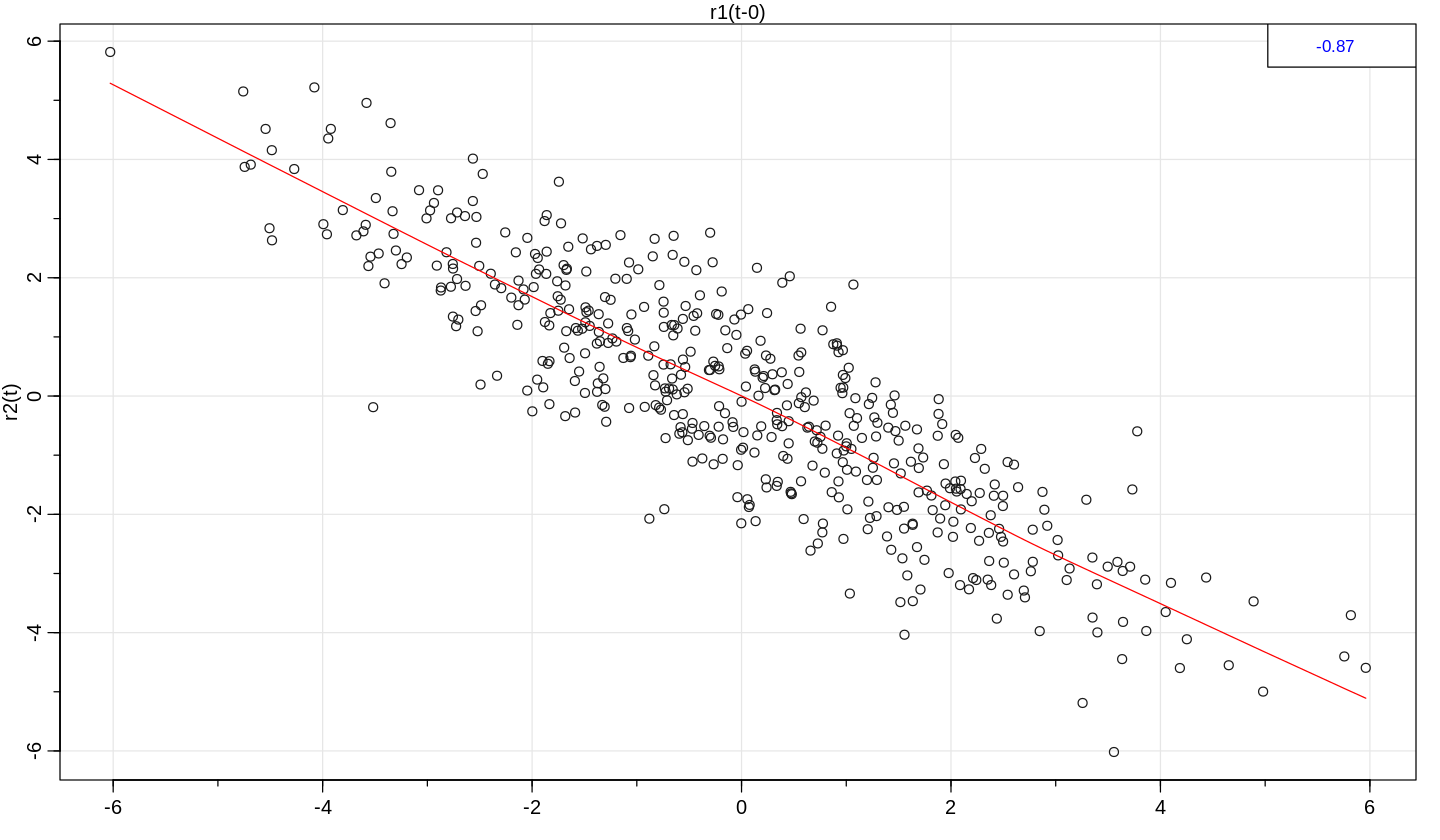

In [24]:
lag2.plot(r1,r2)
cor(r1,r2)

El método anterior puede repetirse para todos los lags. Simplemente:

 * Ajusto $x_t$ a $x_{t-1},\ldots,x_{t-p+1}$, obtengo $r_1$.
 * Ajusto $x_{t-p}$ a $x_{t-1},\ldots,x_{t-p+1}$, obtengo $r_2$.
 * Calculo la correlación entre $r_1$ y $r_2$ (o bien ajusto lineal $r_2$ a $r_1$, es lo mismo). Al resultado se le llama *autocorrelación parcial* entre $x_t$ y $x_{t-p}$ (o de lag $p$).
 
 Hagamoslo un paso más ($p=3$) para ver que ya no queda información.

In [25]:
#Realizo el procedimiento anterior
cuatro_series = ts.intersect(x,xt1=lag(x,-1),xt2=lag(x,-2),xt3=lag(x,-3))

#Ajusto r1
fit1 <- lm(x~0+xt1+xt2,data=cuatro_series)
r1=residuals(fit1)
#Ajusto r2
fit2 <- lm(xt3~0+xt1+xt2,data=cuatro_series)
r2=residuals(fit2)

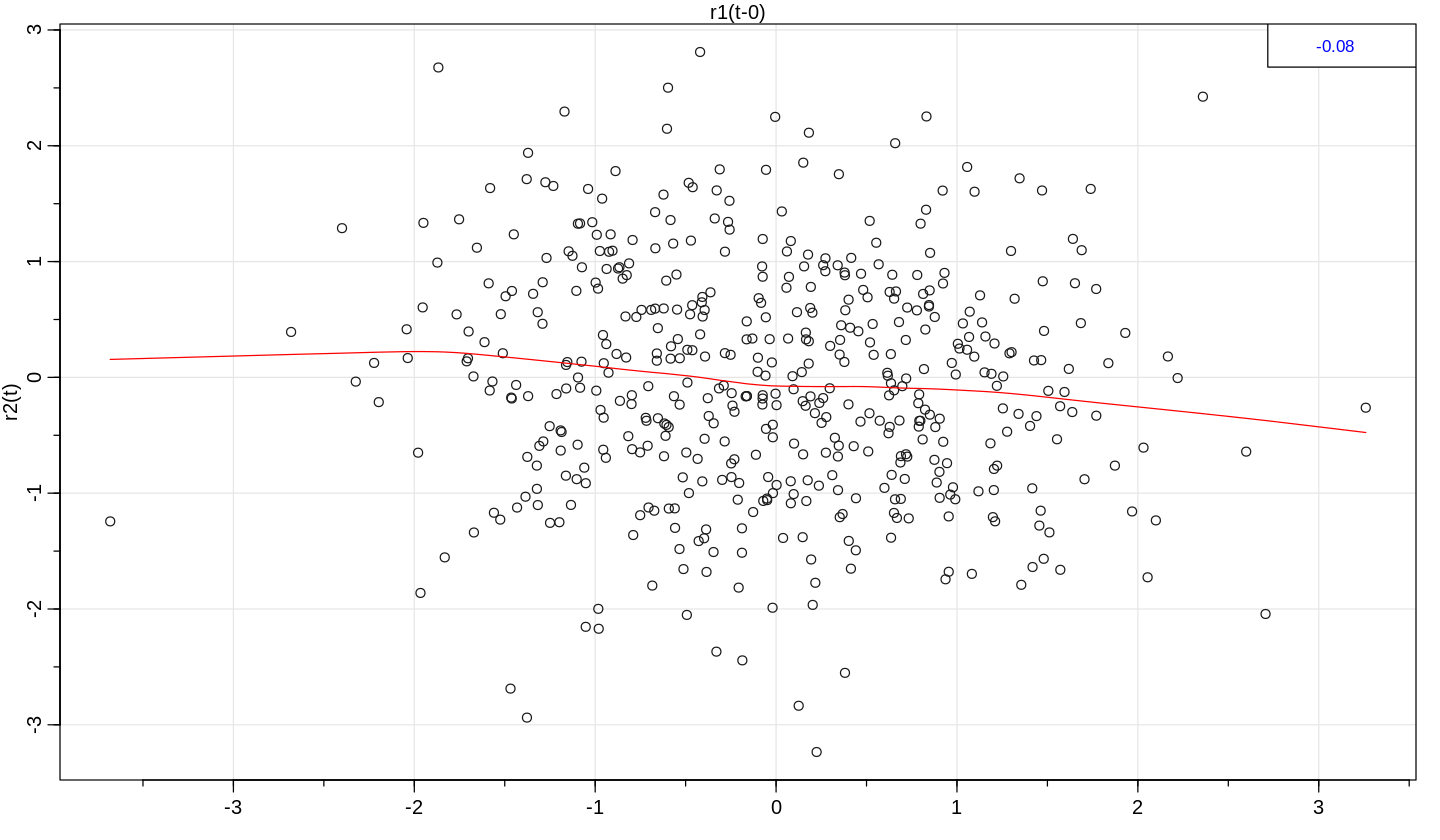

In [26]:
lag2.plot(r1,r2)

### Función de autocorrelación parcial (PACF)

* A la función así construida recursivamente se le denomina Función de Autocorrelación Parcial (PACF).
* En el ejemplo anterior, la PACF(1) coincide con la CCF(1). La PACF(2) *NO* (es otra información).
* En el proceso AR(2), la PACF(2) era significativa, la PACF(3) se vuelve 0.
* En general, si un proceso es AR($p$), entonces la PACF se "apaga" luego de $p$.

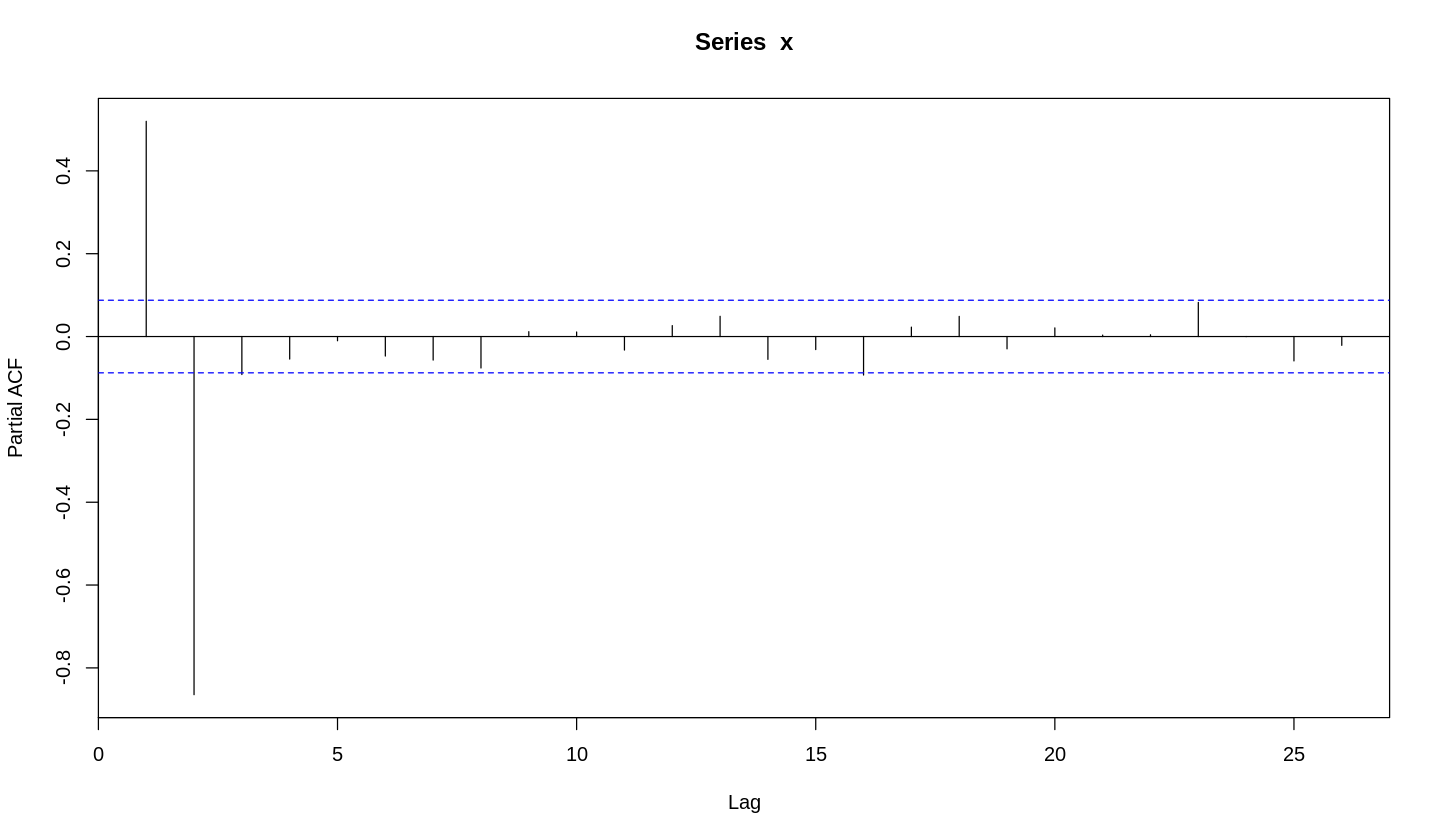

In [27]:
#En R, podemos calcular la PACF usando el algoritmo de Durbin-Levinson:
pacf(x)

Apliquemos la misma idea al proceso AR(1) que teníamos antes

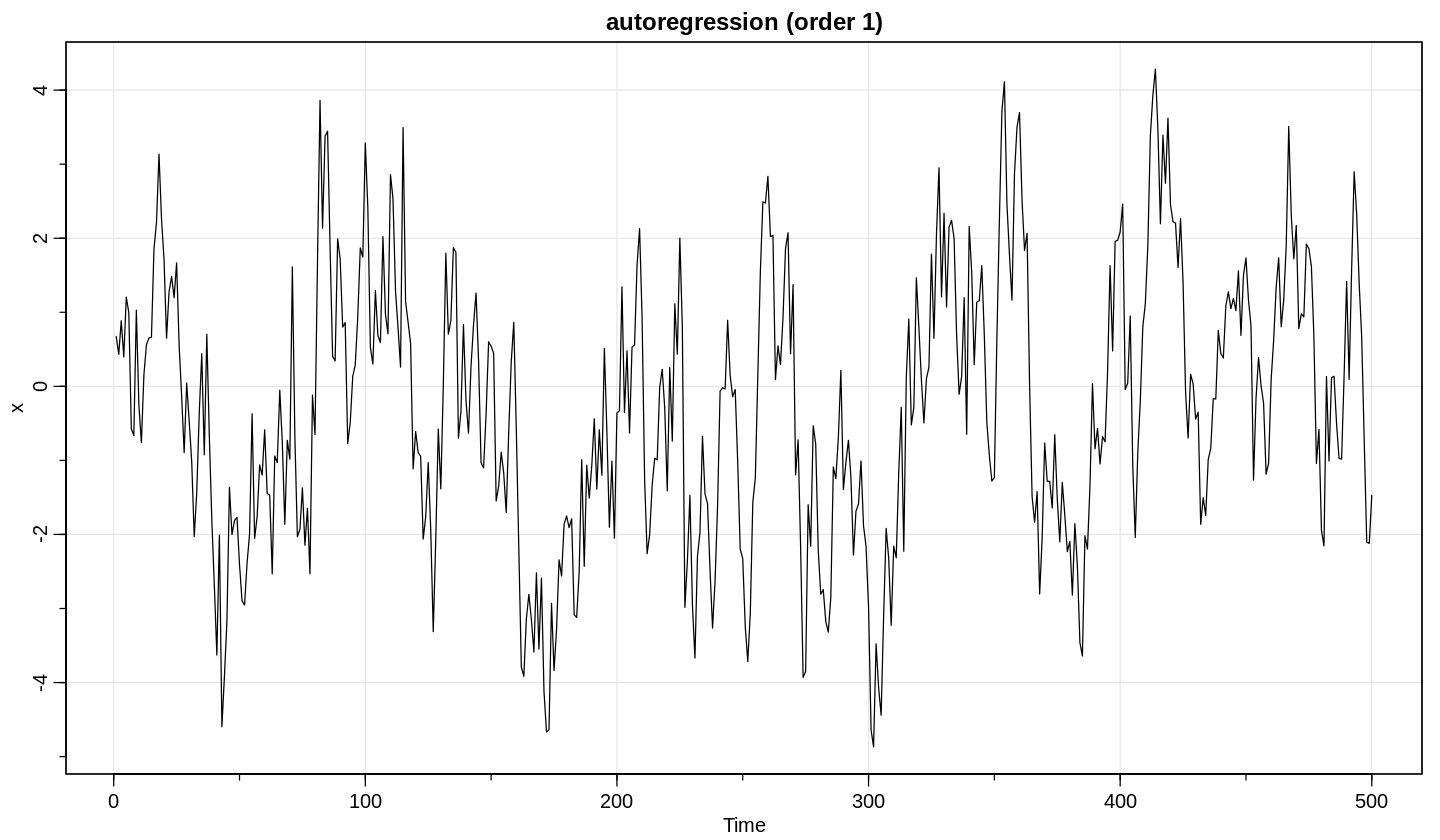

In [28]:
#esto se construye con el comando "filter" de R
x = filter(w, filter=c(0.9), method="recursive")
tsplot(x, main="autoregression (order 1)")

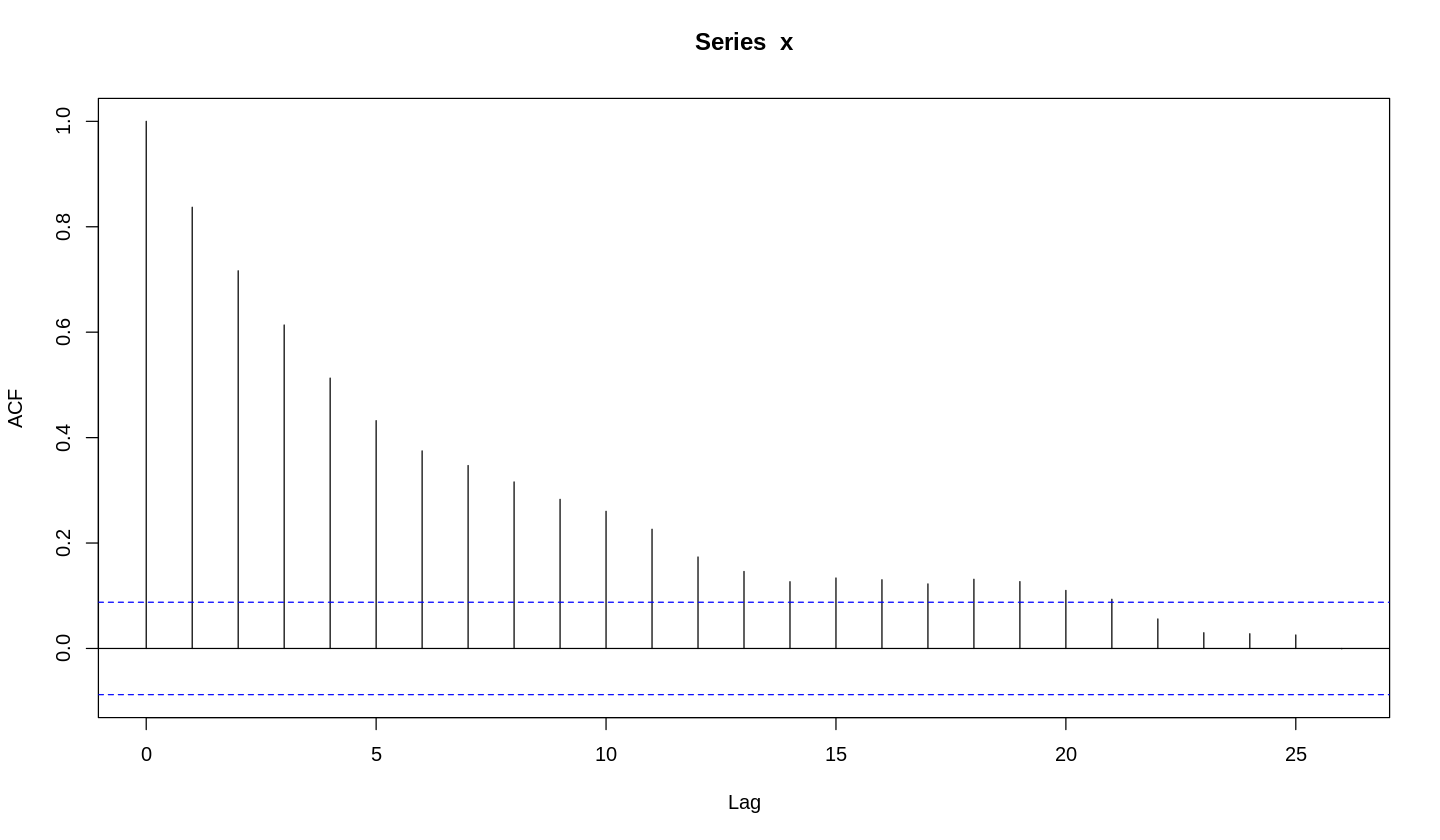

In [29]:
acf(x)

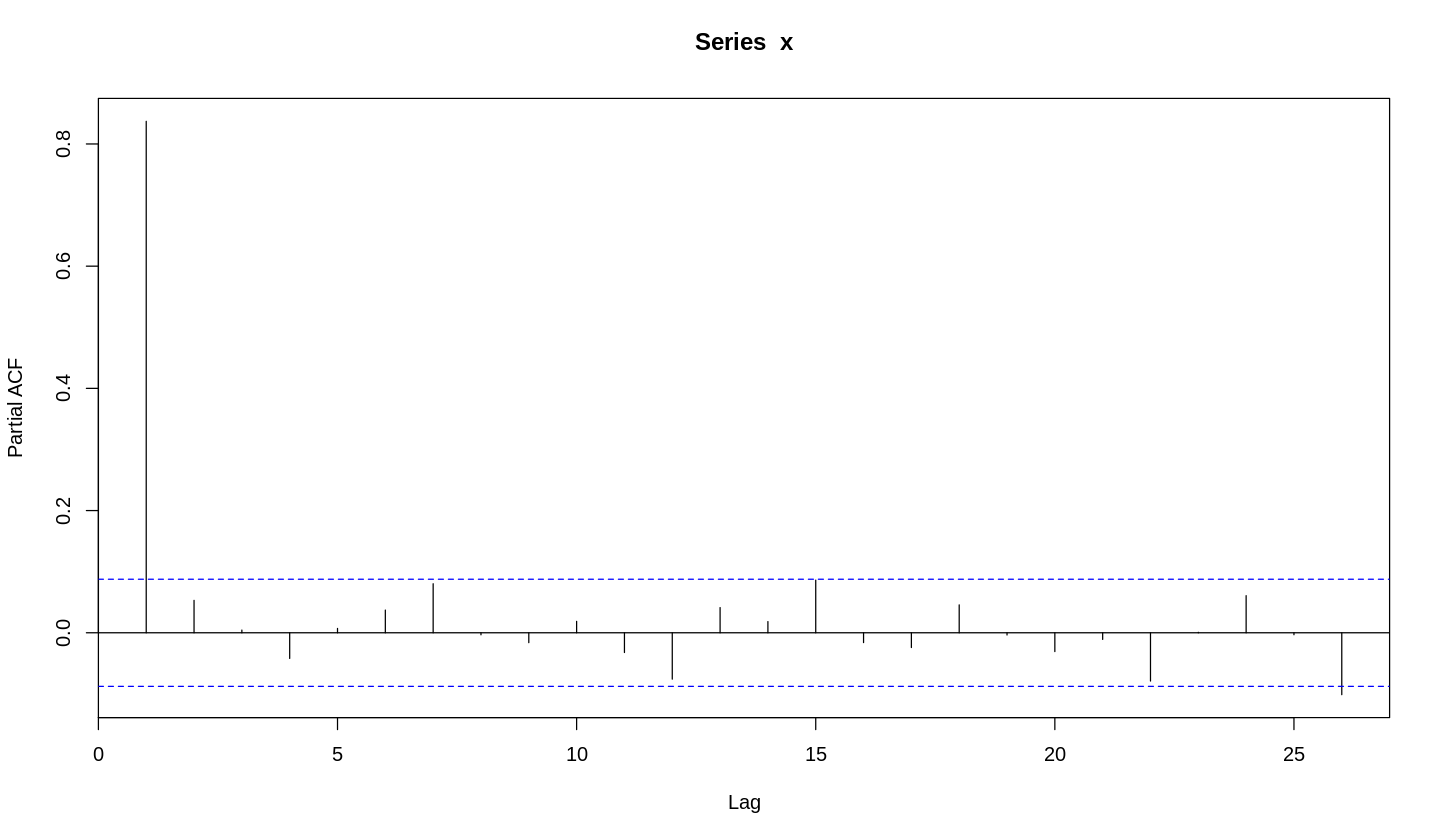

In [30]:
pacf(x)

## Resumen

* En un proceso autorregresivo puro, el valor de la serie en tiempo $t$ depende de los $p$ anteriores más una innovación o ruido en ese punto.

* Por lo tanto, todas las muestras anteriores tienen influencia en la muestra actual (aunque decae exponencialmente).

* La función de autocorrelación entonces decae a $0$ exponencialmente, pero no se anula.

* La función de autocorrelación *parcial* elimina las dependencias internas y permite estimar el orden de un autorregresivo puro.

* Una vez que conocemos el orden, podemos hacer regresión para hallar los coeficientes. `fit<- lm(x~xt1+xt2+xt3...)`

## Predicción a futuro

El siguiente paso es, una vez ajustado un proceso autorregresivo, predecir sus valores a futuro.

Idealmente, queremos hallar:
$$\hat{x}_{n+m} = g(x_1,\ldots,x_n)$$
de modo que:
$$MSE = E[(x_{n+m} - \hat{x}_{n+m})^2]$$
se minimice.


El estimador ideal es la esperanza condicional:

$$\hat{x}_{n+m} = E[x_{n+m} \mid x_1,\ldots,x_n]$$

En el caso de procesos lineales ARMA, este estimador se puede calcular mediante el algoritmo de Durbin-Levinson que veremos más adelante. Sin embargo, en el caso del autorregresivo puro es más simple. Una vez que se conocen los parámetros del modelo:

$$x_{t} = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \ldots + \phi_p x_{t-p} + w_t.$$

Entonces la mejor predicción de $x_{p+1}$ es simplemente realizar la combinación lineal de los últimos $p$ valores:
$$\hat{x}_{n+1} = \phi_1 x_{n} + \phi_2 x_{n-1} + \ldots + \phi_p x_{n-p+1}$$

y luego recursivamemte se pueden construir las estimaciones de $x_{n+2},x_{n+3},\ldots$ etc.



### Ejemplo:

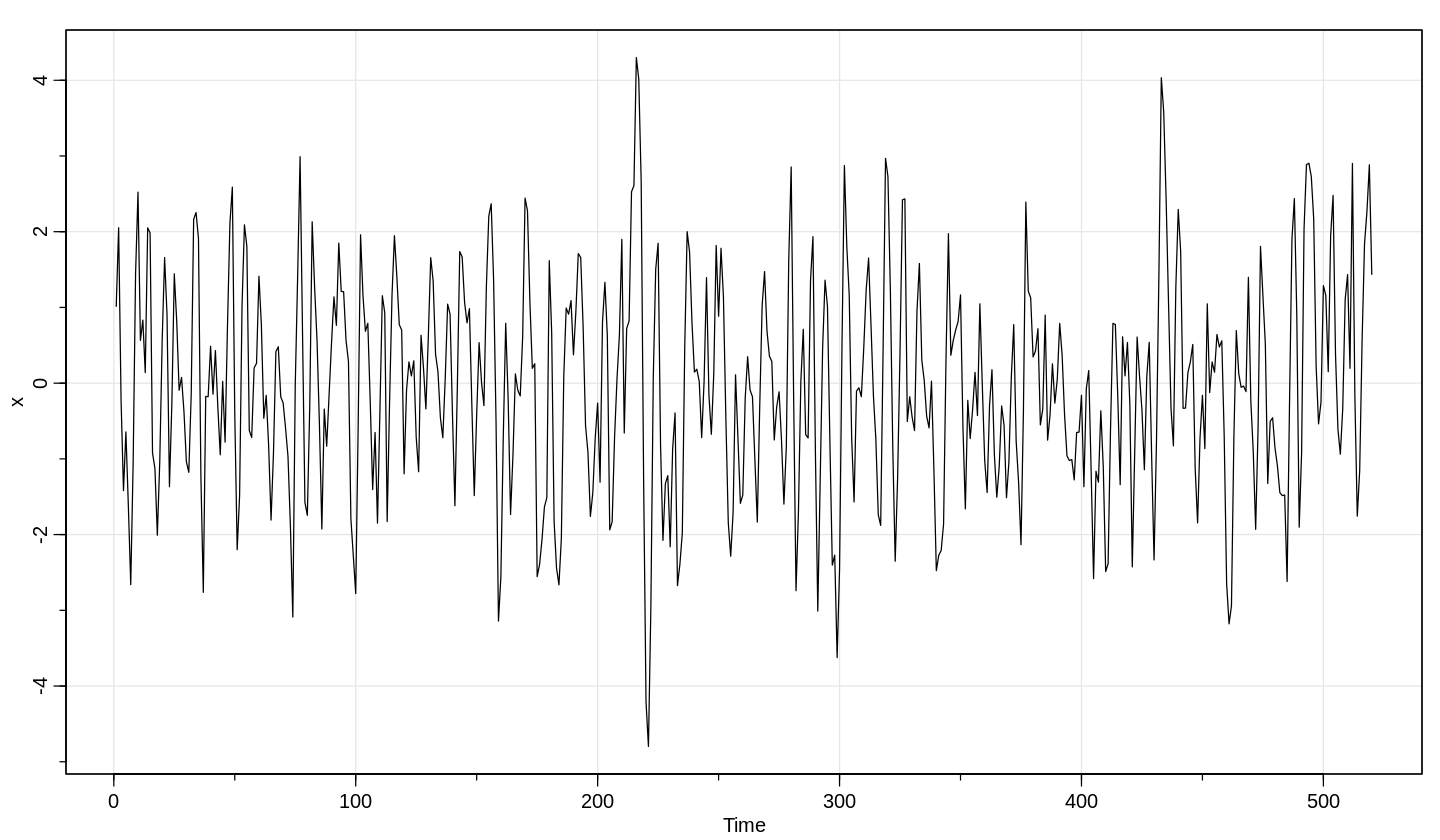

In [31]:
##Simulamos un AR(2) usando ahora la función propia de R
# order=c(p,q,r) quiere decir p=orden del AR, q=orden del MA, r = orden del integrador.
# order=c(2,0,0) es un AR(2) puro, el parámetro ar le pasa los coeficientes.

x = arima.sim(list(order=c(2,0,0), ar=c(.9,-.5)), n=520)
x=ts(x)
tsplot(x)

Ajustamos los coeficientes con los primeros 500 datos y predecimos los otros 20.

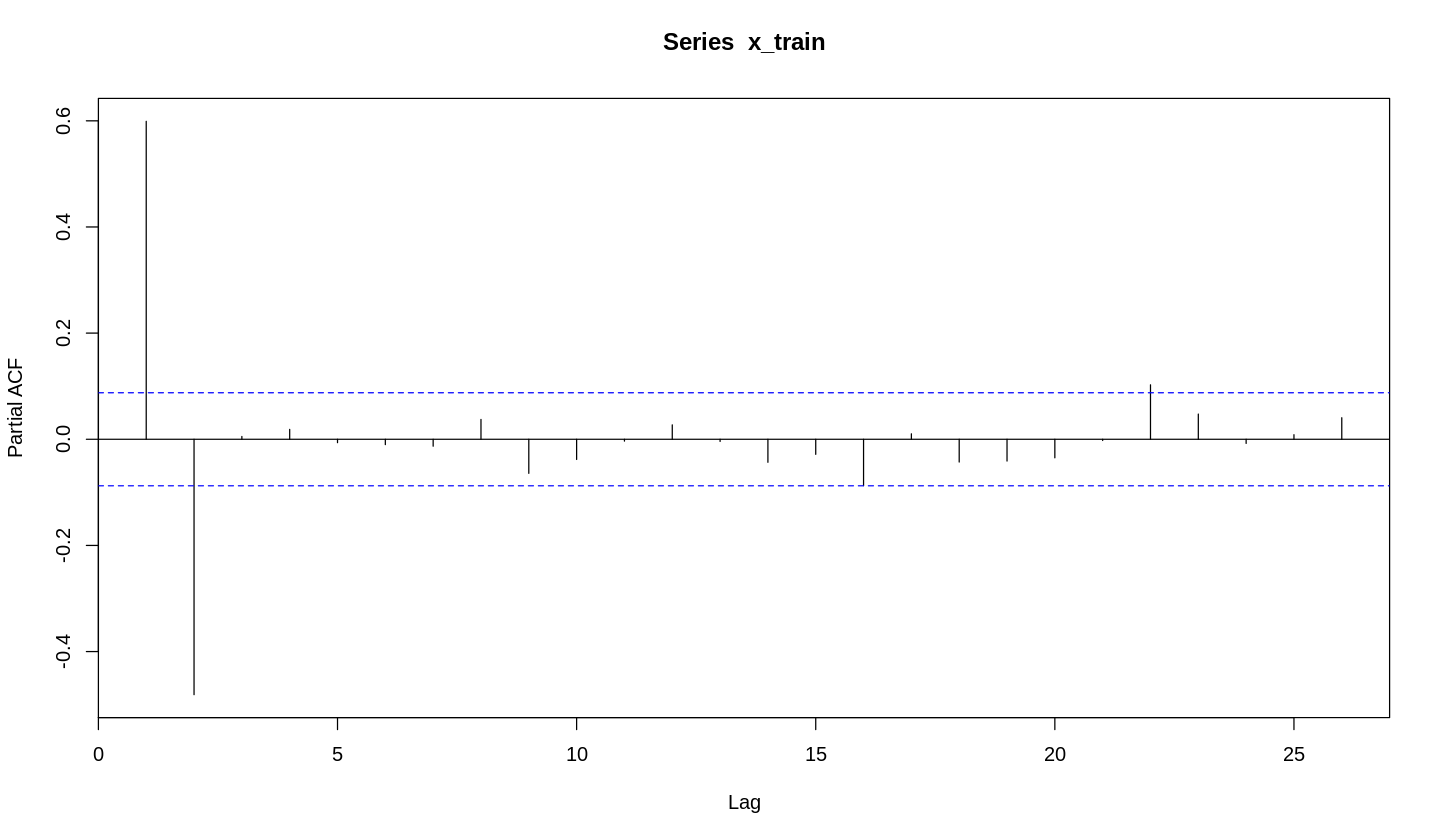

In [32]:
## Recorto la serie
x_train = ts(head(x,500))
## Chequeo la PACF
pacf(x_train)

In [33]:
#Estimo los coeficientes por regresión
tres_series = ts.intersect(x=x_train,xt1=lag(x_train,-1),xt2=lag(x_train,-2))
fit <- lm(x~0+xt1+xt2,data=tres_series)
summary(fit)
phi1 <- fit$coef["xt1"]
phi2 <- fit$coef["xt2"]
phi1
phi2


Call:
lm(formula = x ~ 0 + xt1 + xt2, data = tres_series)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7601 -0.7437 -0.0122  0.6249  3.1961 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1  0.89047    0.03933   22.64   <2e-16 ***
xt2 -0.48228    0.03931  -12.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9821 on 496 degrees of freedom
Multiple R-squared:  0.5097,	Adjusted R-squared:  0.5077 
F-statistic: 257.8 on 2 and 496 DF,  p-value: < 2.2e-16


xt1 
0.8904744

xt2 
-0.4822751

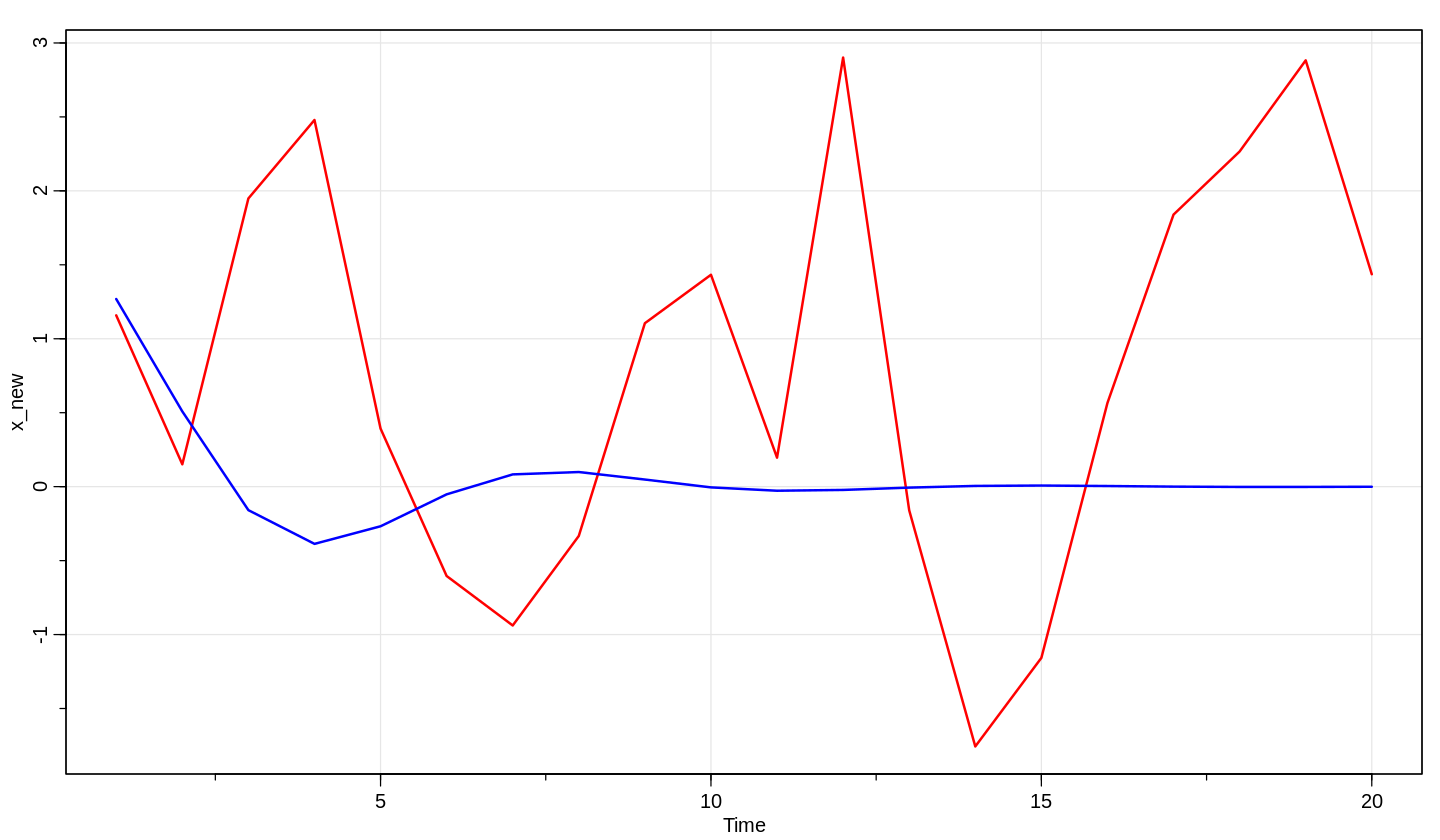

In [34]:
x_new <- ts(tail(x,20))
x_hat <- vector()
x_hat[1] = phi1 * x_train[500] + phi2*x_train[499]
x_hat[2] = phi1 * x_hat[1] + phi2*x_train[500]

for (i in 3:20)
{
    x_hat[i] = phi1 * x_hat[i-1] + phi2*x_hat[i-2]
}

tsplot(x_new,col="red", lwd=2)
lines(x_hat,col="blue", lwd=2)

### Observaciones

* La predicción solo es razonable a pocos intervalos.
* A la larga vuelve a la media ya que promedia los valores que va obteniendo.
* Dicho de otro modo, como la influencia de los datos hasta $n$ decae exponencialmente después de $n$, es muy difícil predecir más allá de unos pocos pasos.

In [35]:
##Esto es lo mismo, pero hecho con R
fit <- arima(x_train, order = c(2,0,0))
fit


Call:
arima(x = x_train, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      0.8899  -0.4838    -0.0773
s.e.  0.0391   0.0392     0.0738

sigma^2 estimated as 0.9589:  log likelihood = -699.46,  aic = 1406.93

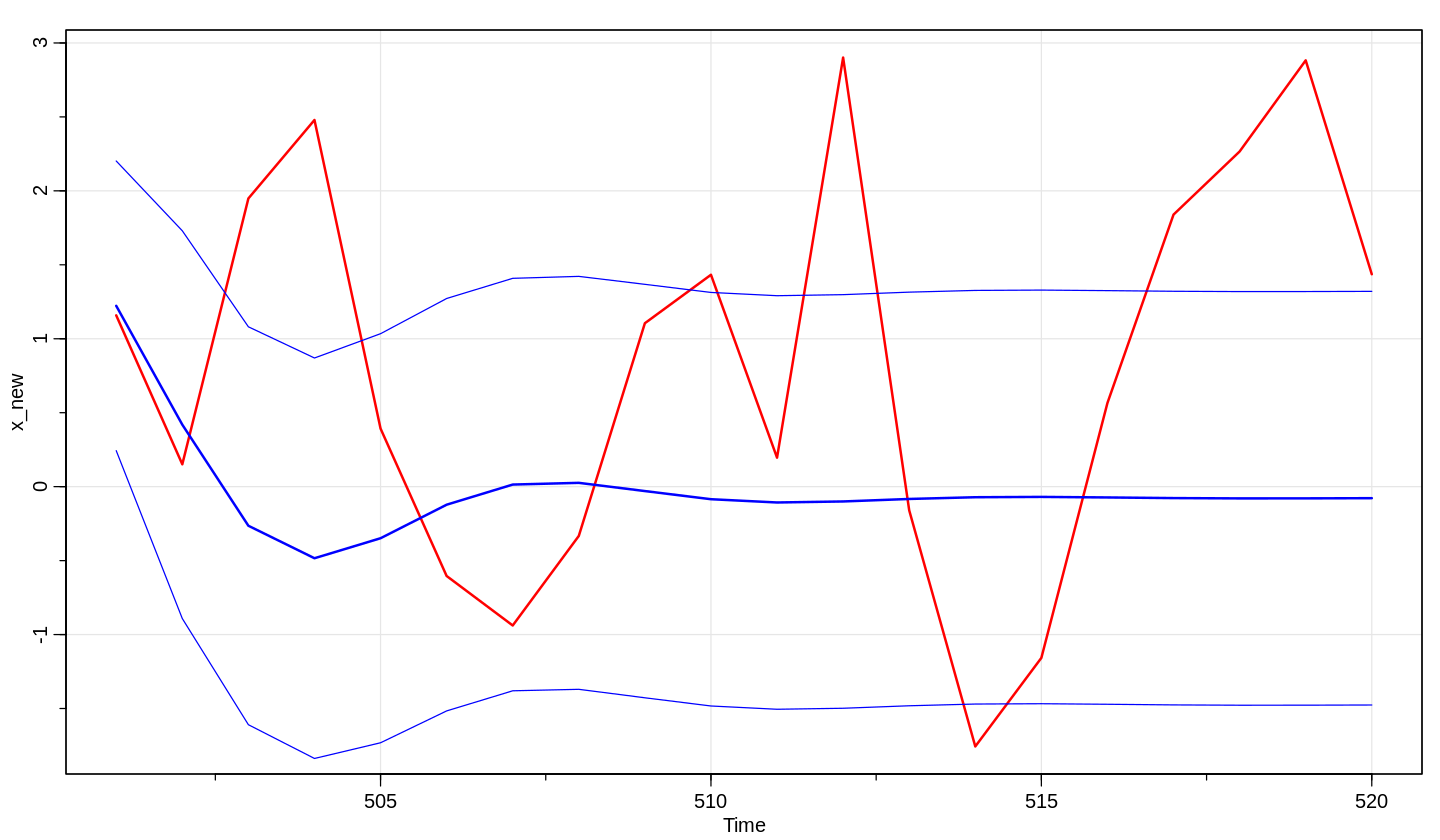

In [36]:
predictions = predict(fit, n.ahead = 20)
x_hat = predictions$pred
se = predictions$se
x_new = ts(tail(x,20),start=501)
tsplot(x_new,col="red", lwd=2)
lines(x_hat,col="blue", lwd=2)
lines(x_hat+se,col="blue", lwd=1)
lines(x_hat-se,col="blue", lwd=1)

### Predicción recursiva

De todos modos, si bien no permite predecir mucho hacia el futuro, podemos ir recursivamente prediciendo el valor $x_{n+1}$ una vez que conocemos $x_{n},x_{n-1},\ldots,x_{n-p+1}$, es decir los últimos $p$.

Luego si recibimos un dato nuevo podemos actualizar la predicción.

### Ejemplo

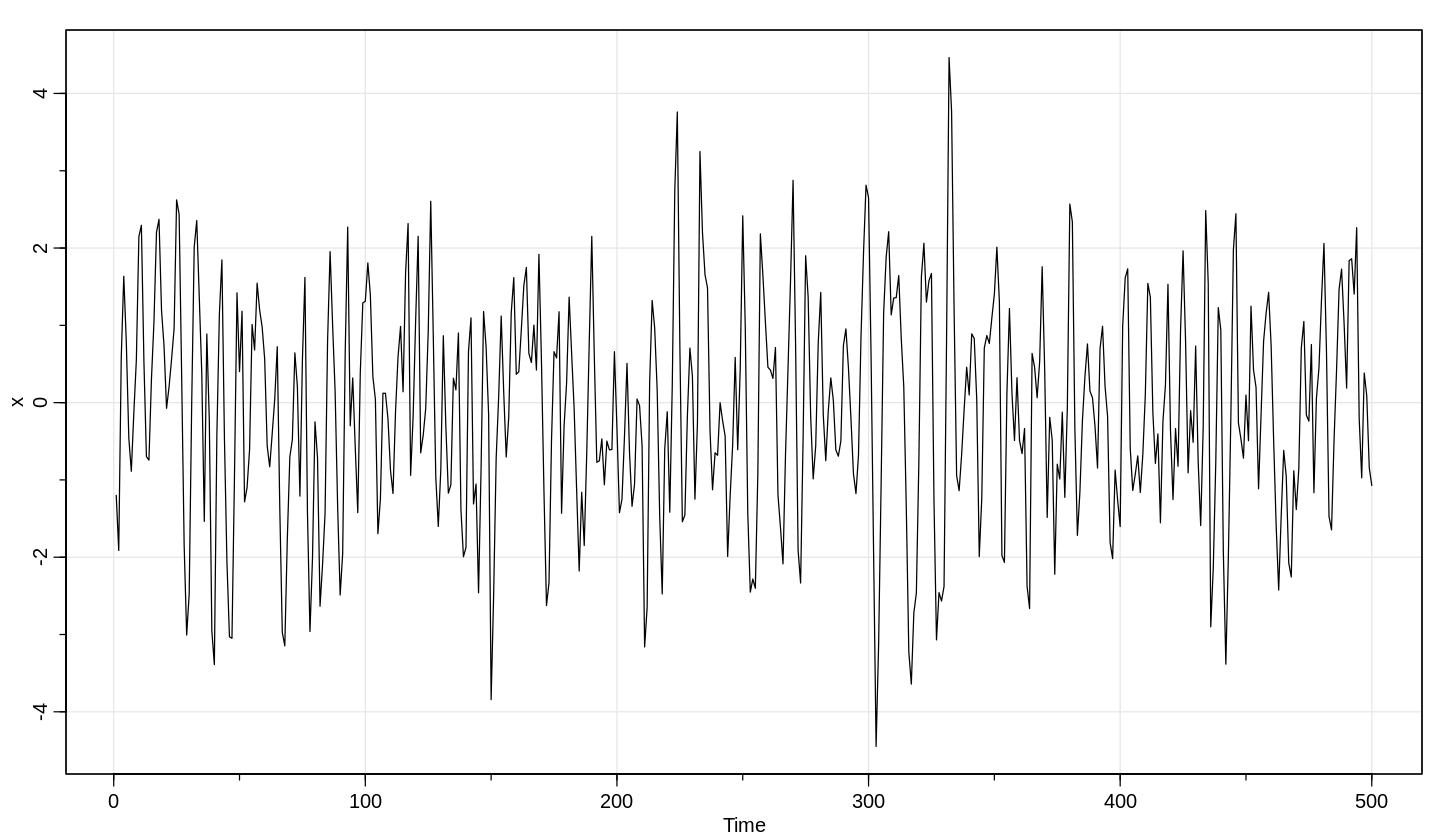

In [37]:
##Simulamos un AR(2) usando ahora la función propia de R
# order=c(p,q,r) quiere decir p=orden del AR, q=orden del MA, r = orden del integrador.
# order=c(2,0,0) es un AR(2) puro, el parámetro ar le pasa los coeficientes.

x = arima.sim(list(order=c(2,0,0), ar=c(.9,-.5)), n=500)
x=ts(x)
tsplot(x)

Supongamos que sabemos exactamente los parámetros, en este caso media $\mu=0$, $\phi_1=0.9$ y $\phi_2=-0.5$.

 * Si solo predecimos por la media, el error MSE es el desvío estándar de la serie.
 * Si predecimos recursivamente $x_{t+1}$ por $\hat{x}_{t+1} = \phi_1 x_t + \phi_2 x_{t-1}$ entonces deberíamos poder reducir el error.

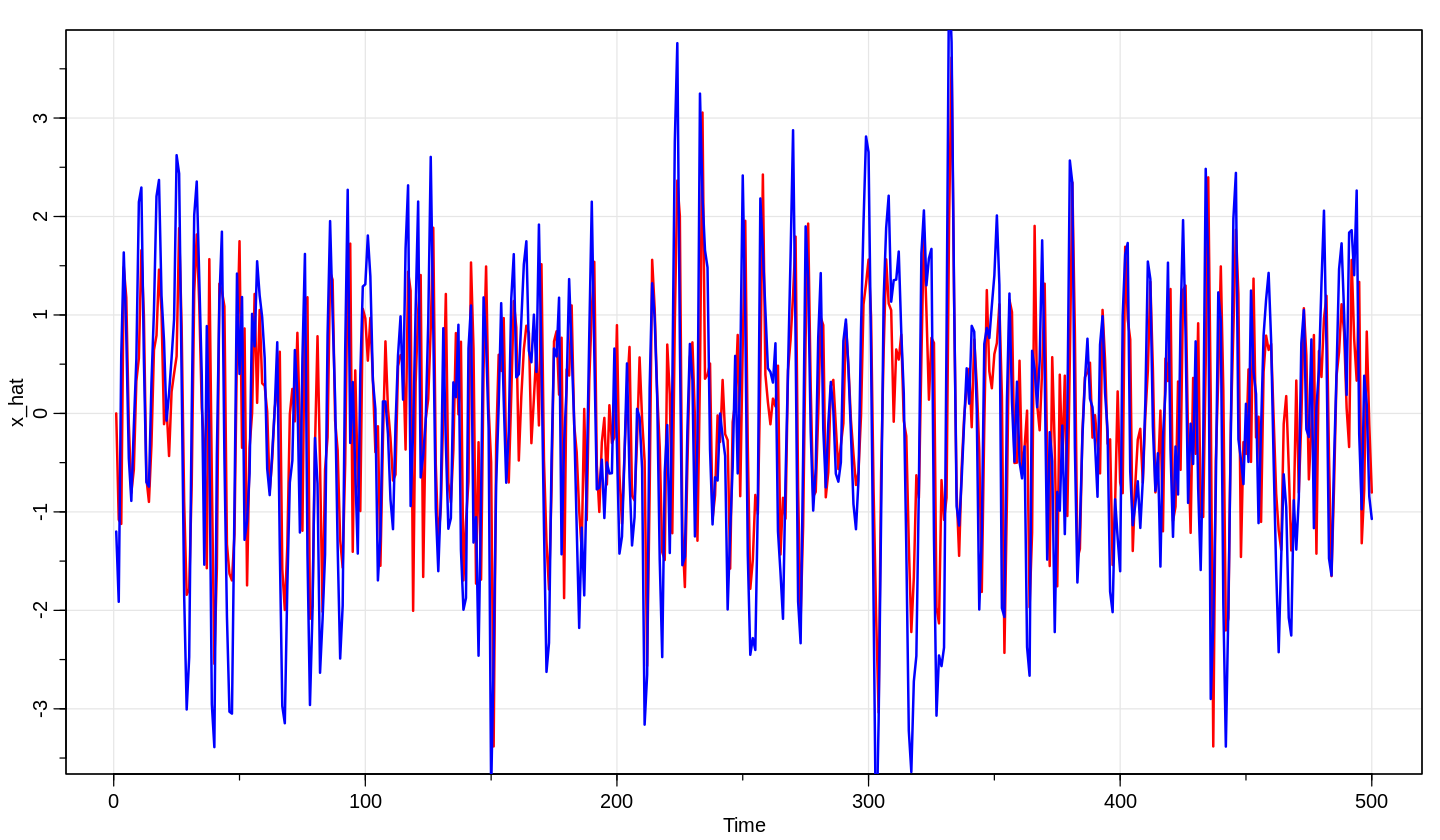

In [38]:
phi1 = 0.9
phi2 = -0.5

x_hat <- vector()
x_hat[1] = 0
x_hat[2] = phi1 * x[1]

for (i in 3:500)
{
    x_hat[i] = phi1 * x[i-1] + phi2*x[i-2]
}
x_hat=ts(x_hat)
tsplot(x_hat,col="red", lwd=2)
lines(x,col="blue", lwd=2)

In [39]:
##Residuo
residuals = x-x_hat
MSE = sd(residuals)
MSE
sd(x)

[1] 1.005722

[1] 1.414459

## Ejercicio 1:

Analizar la serie `cmort` de mortalidad cardiovascular en Los Angeles y ajustar un modelo autorregresivo de orden adecuado a la misma. Predecir la mortalidad cardiovascular del año siguiente. No olvidar primero estimar la tendencia. Si quieren, pueden proponer además una componente estacional.

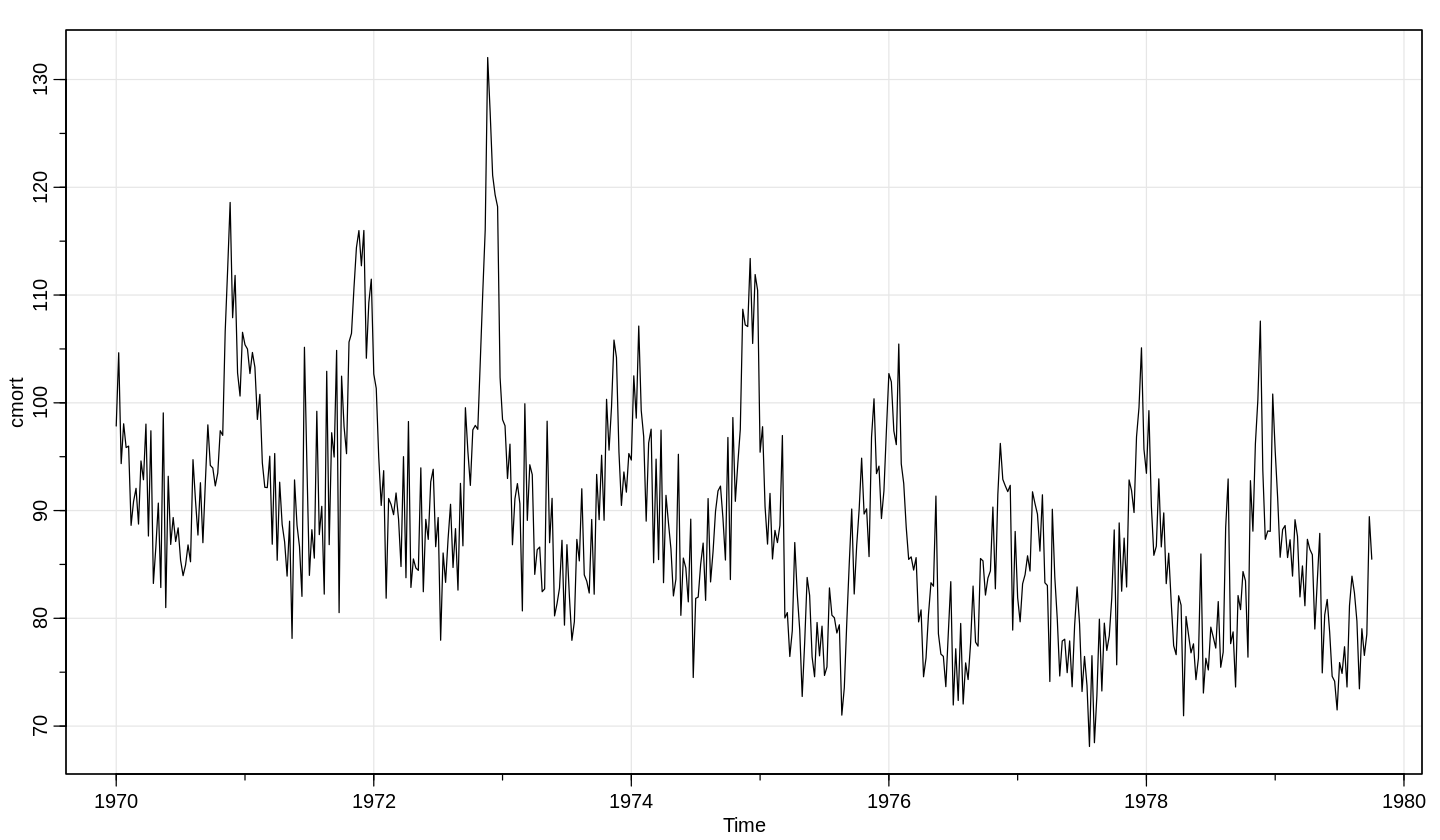

In [40]:
tsplot(cmort)

## Ejercicio 2 (diferencias para estacionariedad)

Considere la serie `gnp` de producto bruto interno de EEUU incluida en la biblioteca `astsa`. La serie contiene el PBI de EEUU trimestral de 1947 a 2002 ($n=223$), en billones de dólares de 1996, ajustado estacionalmente.

 1. Analice el comportamiento de la serie. ¿Es estacionaria?
 2. Considere la transformación log(gnp). Proponga un ajuste lineal para la tendencia.
 3. Ajuste un modelo autorregresivo a los residuos de la serie. Analice el error cometido.
 4. Se propone ahora como forma de estacionarizar la serie tomar las diferencias de valores consecutivos usando el comando  `diff`. Notar que esta transformación deja el crecimiento relativo de la serie.
 5. Ajuste nuevamente un modelo autorregresivo a los residuos (no olvide la media) y analice el error.
 6. Repita lo anterior usando las primeras 200 observaciones, y propóngase estimar las restantes 23. ¿Cuál de los dos modelos predice mejor?